## Analysis
Do the following analyses:
1. Plot mean rewards together for all runs by task
2. Plot success rate together for all runs by task
3. Plot Quantile of rewards together for all runs by task
4. Evaluate gating values and performance

Need a way of splitting out algorithm, task, run

In [24]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from plotting_utils import *

In [61]:
EXPERIMENT_LOG = '../../experiment_log.csv'
experiment_log = pd.read_csv(EXPERIMENT_LOG)

In [62]:
push_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='push-v2', setting='random')
reach_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='reach-v2', setting='random')
pick_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='pick-place-v2', setting='random')
faucet_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='faucet-open-v2', setting='random')
door_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='door-open-v2', setting='random')
button_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='button-press-v2', setting='random')
reach_wall_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='reach-wall-v2', setting='random')
push_wall_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='push-wall-v2', setting='random')
bin_pick_experiments = resultsManager(experiment_log_loc=EXPERIMENT_LOG, environment='bin-picking-v2', setting='random')

In [63]:
all_experiments = [
    push_experiments,
    reach_experiments,
    pick_experiments,
    faucet_experiments,
    door_experiments,
    button_experiments,
    reach_wall_experiments,
    push_wall_experiments,
    bin_pick_experiments
]
test_data = pd.concat([experiment.get_result_group_data('test_results') for experiment in all_experiments])
train_data = pd.concat([experiment.get_result_group_data('train_results') for experiment in all_experiments])
left_eval_data = pd.concat([experiment.get_result_group_data('left_eval_results') for experiment in all_experiments])
# train_data = pd.concat(faucet_experiments.get_result_group_data('train_results')
# left_eval_data = faucet_experiments.get_result_group_data('left_eval_results')


In [64]:
## constants
WINDOW = 100
MIN_OVER = 1e6
TO_REMOVE = [
    'random', 
    'right_only', 
    'right_only_double_params', 
    'right_only_double_params_train', 
    'right_only_train', 
    'random_train'
]
TRAINING_TASKS = [
    'reach-v2', 'push-v2', 'pick-place-v2',
    'reach-wall-v2', 'push-wall-v2', 'bin-picking-v2',
    'faucet-open-v2', 'door-open-v2', 'button-press-v2'
]

LABEL_MAPPING = {
    'bicameral_w_gating_schedule': 'Gating Schedule',
    'bicameral_w_gating_encoder': 'Gating Network (no penalty)',
    'bicameral_w_gating_encoder+penalty':'Gating Network (with penalty)',
    'right_only_double_params': 'Right-only Baseline',
    'left_only_double_params': 'Left-only Baseline',
    'random': 'Random',
    'right_only': 'Right-hemisphere'
}

## FOR PLOT STYLES
sns.set_theme()
sns.set(font_scale=1.75)

# 1. worst-case uplift


(-239500.0, 5249500.0, 0.9804597850000001, 9.911973914999999)

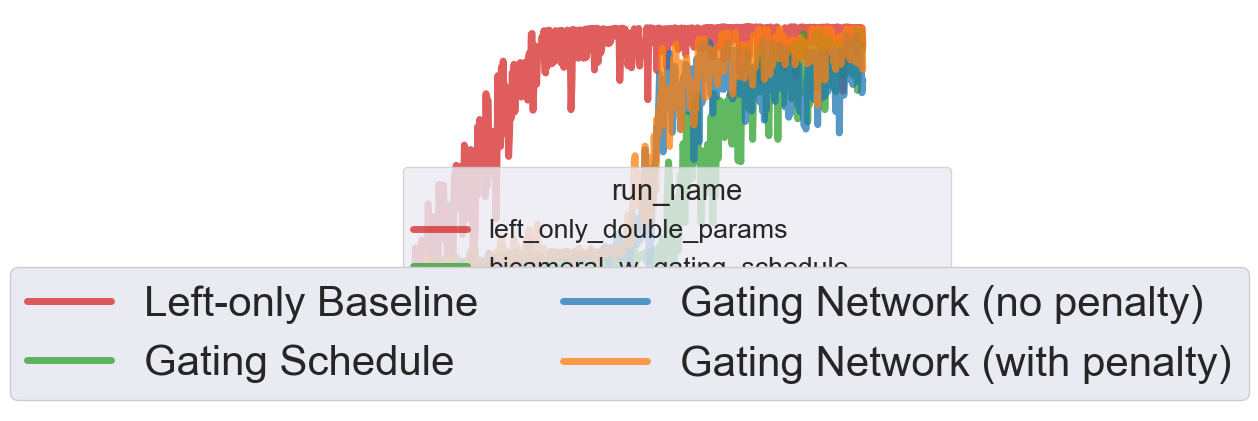

In [65]:
### get a legend
algs_to_legend = [k for k in LABEL_MAPPING.keys() if 'bicameral' in k] + ['left_only_double_params']
#list(LABEL_MAPPING.keys())
fig, ax = plt.subplots()
sns.lineplot(
    data=(
        train_data
        .query('training_task=="faucet-open-v2"')
        .query(f'run_name.isin({algs_to_legend})')
    ),
    x='frame',
    y='reward_mean',
    hue='run_name',
    palette=PALETTE,
    alpha=0.75,
    linewidth=5
)

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(
    handles, 
    [LABEL_MAPPING[lab] for lab in labels], 
    loc = 'lower center',
    fontsize='x-large', 
    title_fontsize='40',  
    ncol=len(algs_to_legend)/2,
    framealpha=1)
plt.axis('off')

In [66]:
def plot_reward_trajectory(
    df, reward_col, window, min_over, tasks, to_remove,
    title, ylabel, figsize=(21, 14), use_left_median=False, use_left_min=False):
    """
    Plots a specified reward col with specified smoothing
    Option to present as ratio to left-only baseline results
    """
    to_plot = get_median_vs_left_min(
        df = df.query(f"~run_name.isin({to_remove})"),
        reward_col = reward_col,
        window = window,
        min_over = min_over,
        use_left_median=use_left_median,
        use_left_min=use_left_min
    )

    ## set out plots by task - assume tasks are 3x3 for now
    fig, ax = plt.subplots(3,3, figsize=figsize, sharex=True)
    ax = ax.flatten()
    fig.suptitle(title)

    for i, task in enumerate(tasks):

        sns.lineplot(
            data = to_plot.query(f"training_task=='{task}'"),
            x='frame',
            y=reward_col,
            hue='run_name',
            ax = ax[i],
            palette=PALETTE,
            alpha = .75,
            linewidth=3
        )

        ax[i].set(
            title=task, 
            xlabel='Environment Steps',
            ylabel=''
        )
        # if i % 3 == 0:
        #     ax[i].set_ylabel(ylabel)
        # else:
        #     ax[i].set_ylabel('')
        # ax[i].set_ylim(0)

        ## show baselines
        # random
        random_median = (
            df
            .query('run_name=="random"')
            .query(f'training_task=="{task}"')
            .loc[:,reward_col].median()
        )
        ax[i].axhline(random_median, c=PALETTE['random'], linewidth=3, alpha=.75)

        # right only double
        right_only_median = (
            df
            .query('run_name=="right_only_double_params"')
            .query(f'training_task=="{task}"')
            .loc[:,reward_col].median()
        )
        ax[i].axhline(right_only_median, c=PALETTE['right_only_double_params'], linewidth=3, alpha=.75)
        
        # show left baseline value at 1 if adjust_left
        if use_left_median or use_left_min:
            ax[i].axhline(1, c='black', alpha=.7)
        # if i > 0:
        ax[i].get_legend().remove()

    plt.tight_layout()
    plt.show();

    if use_left_median or use_left_min:
        return to_plot

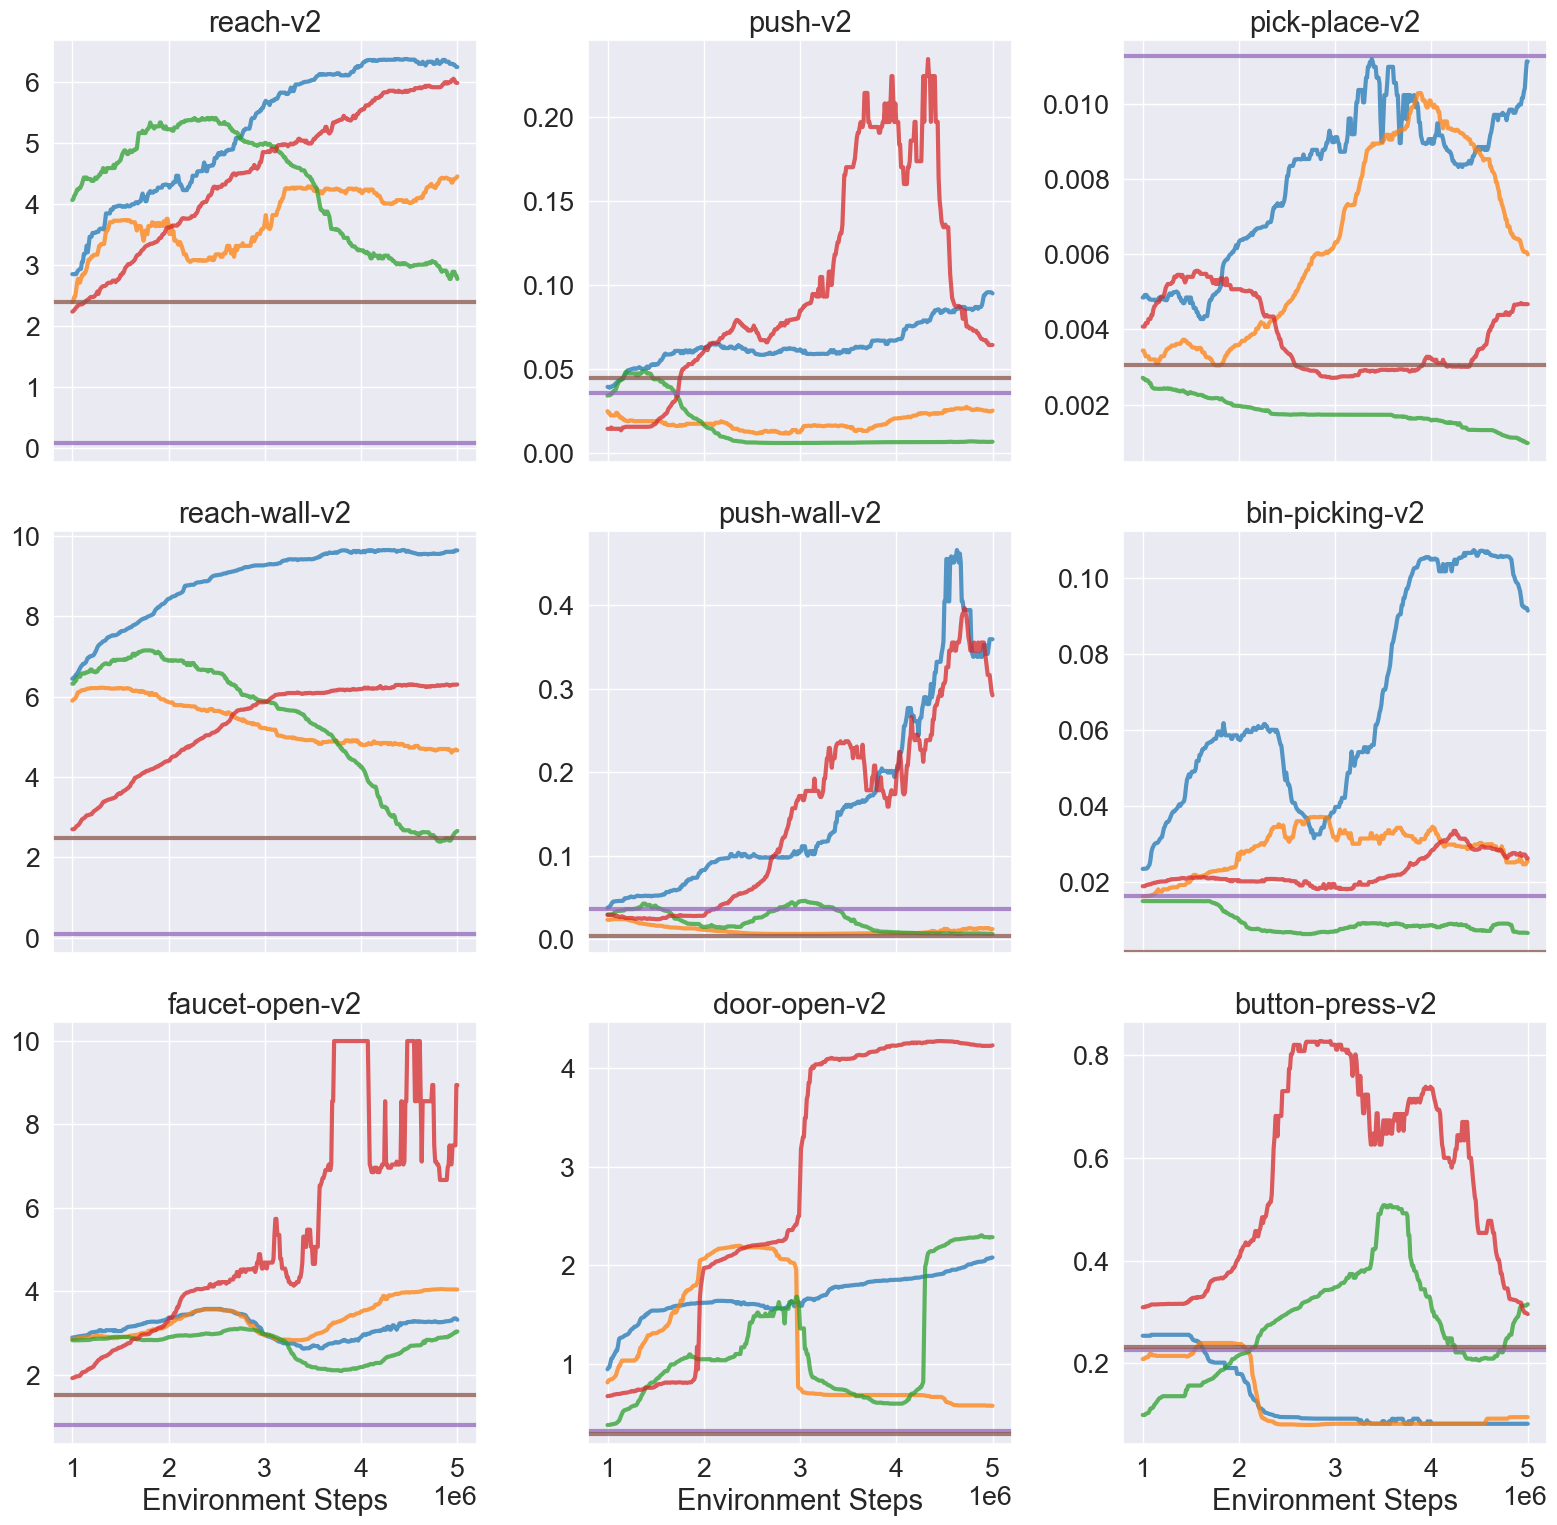

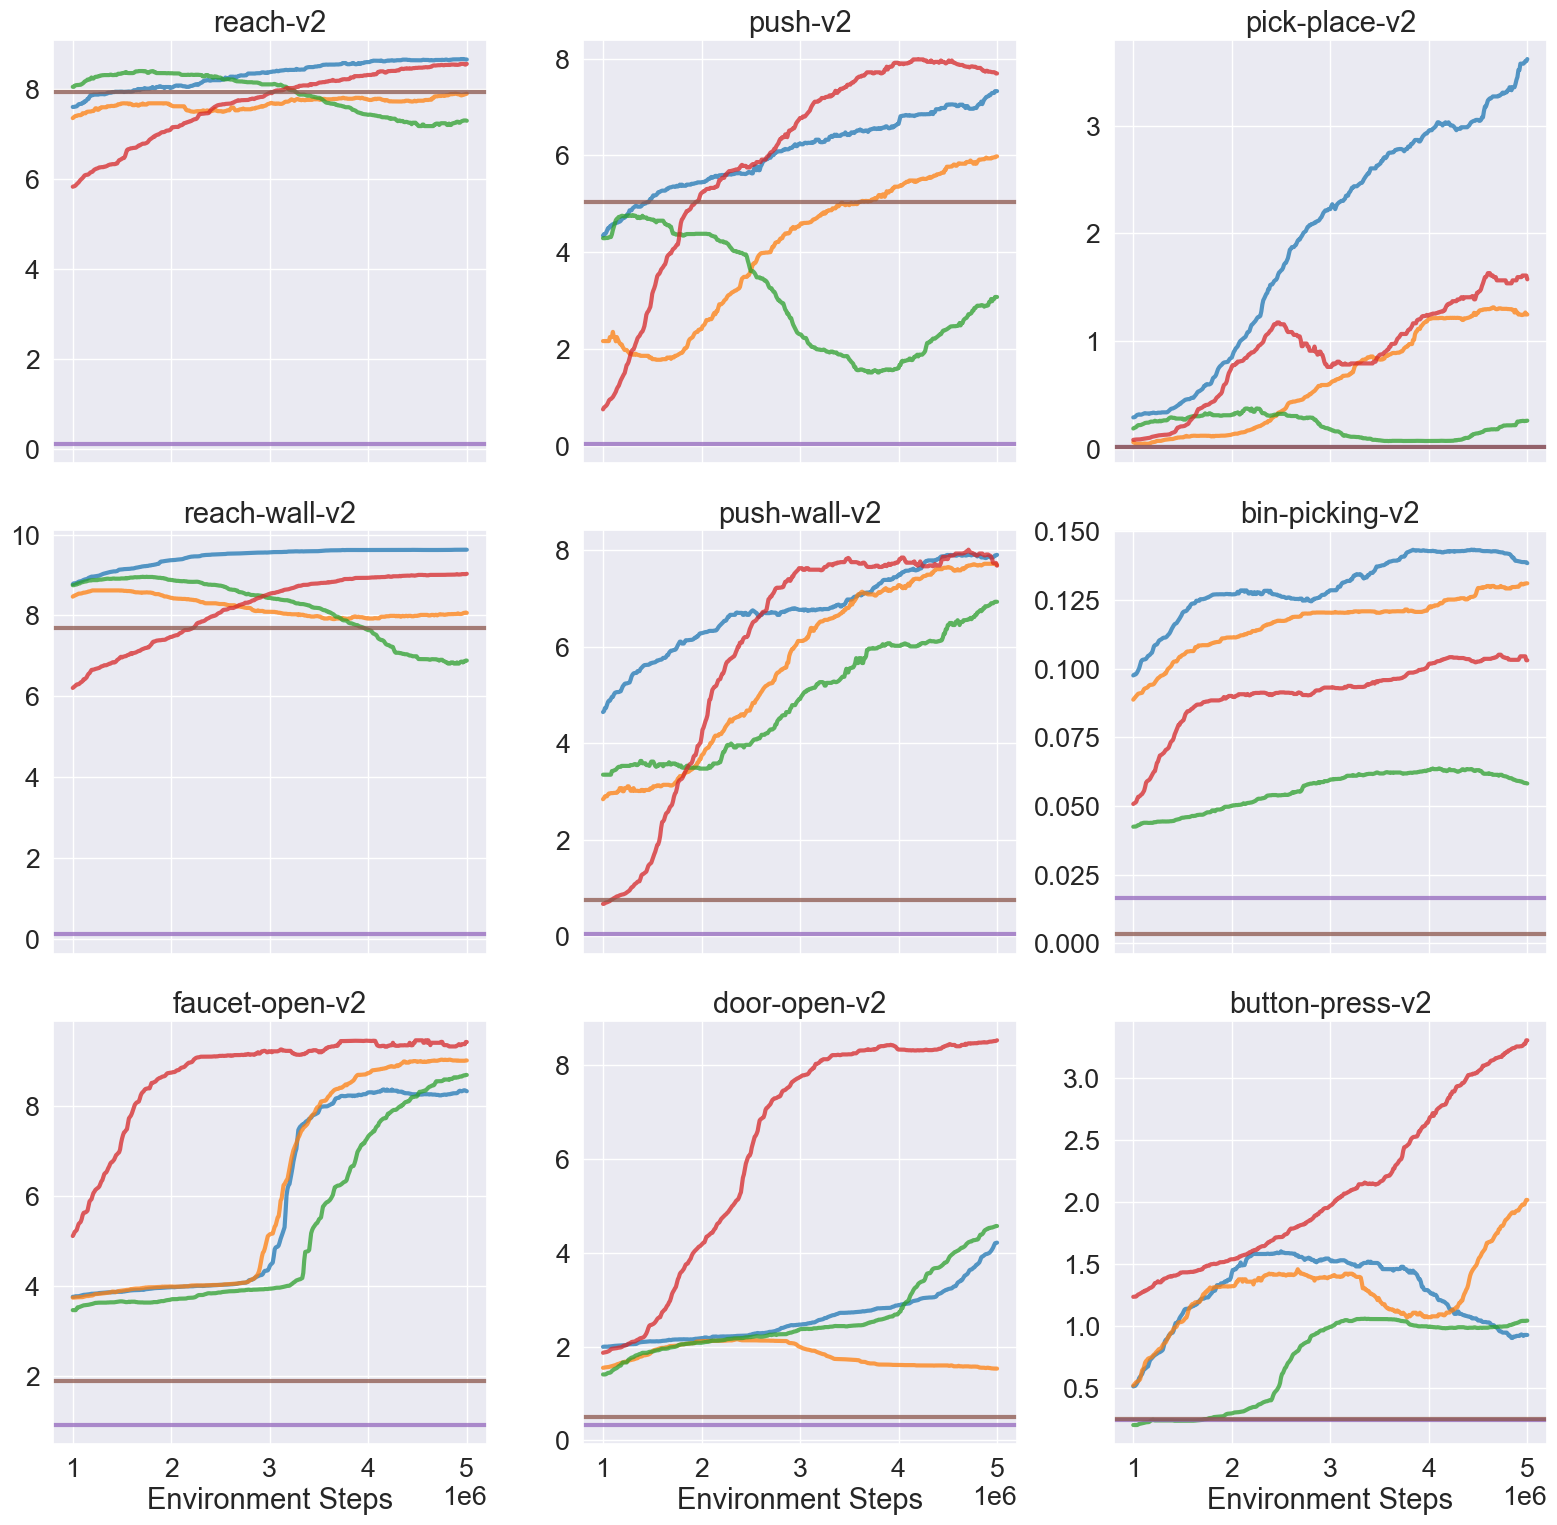

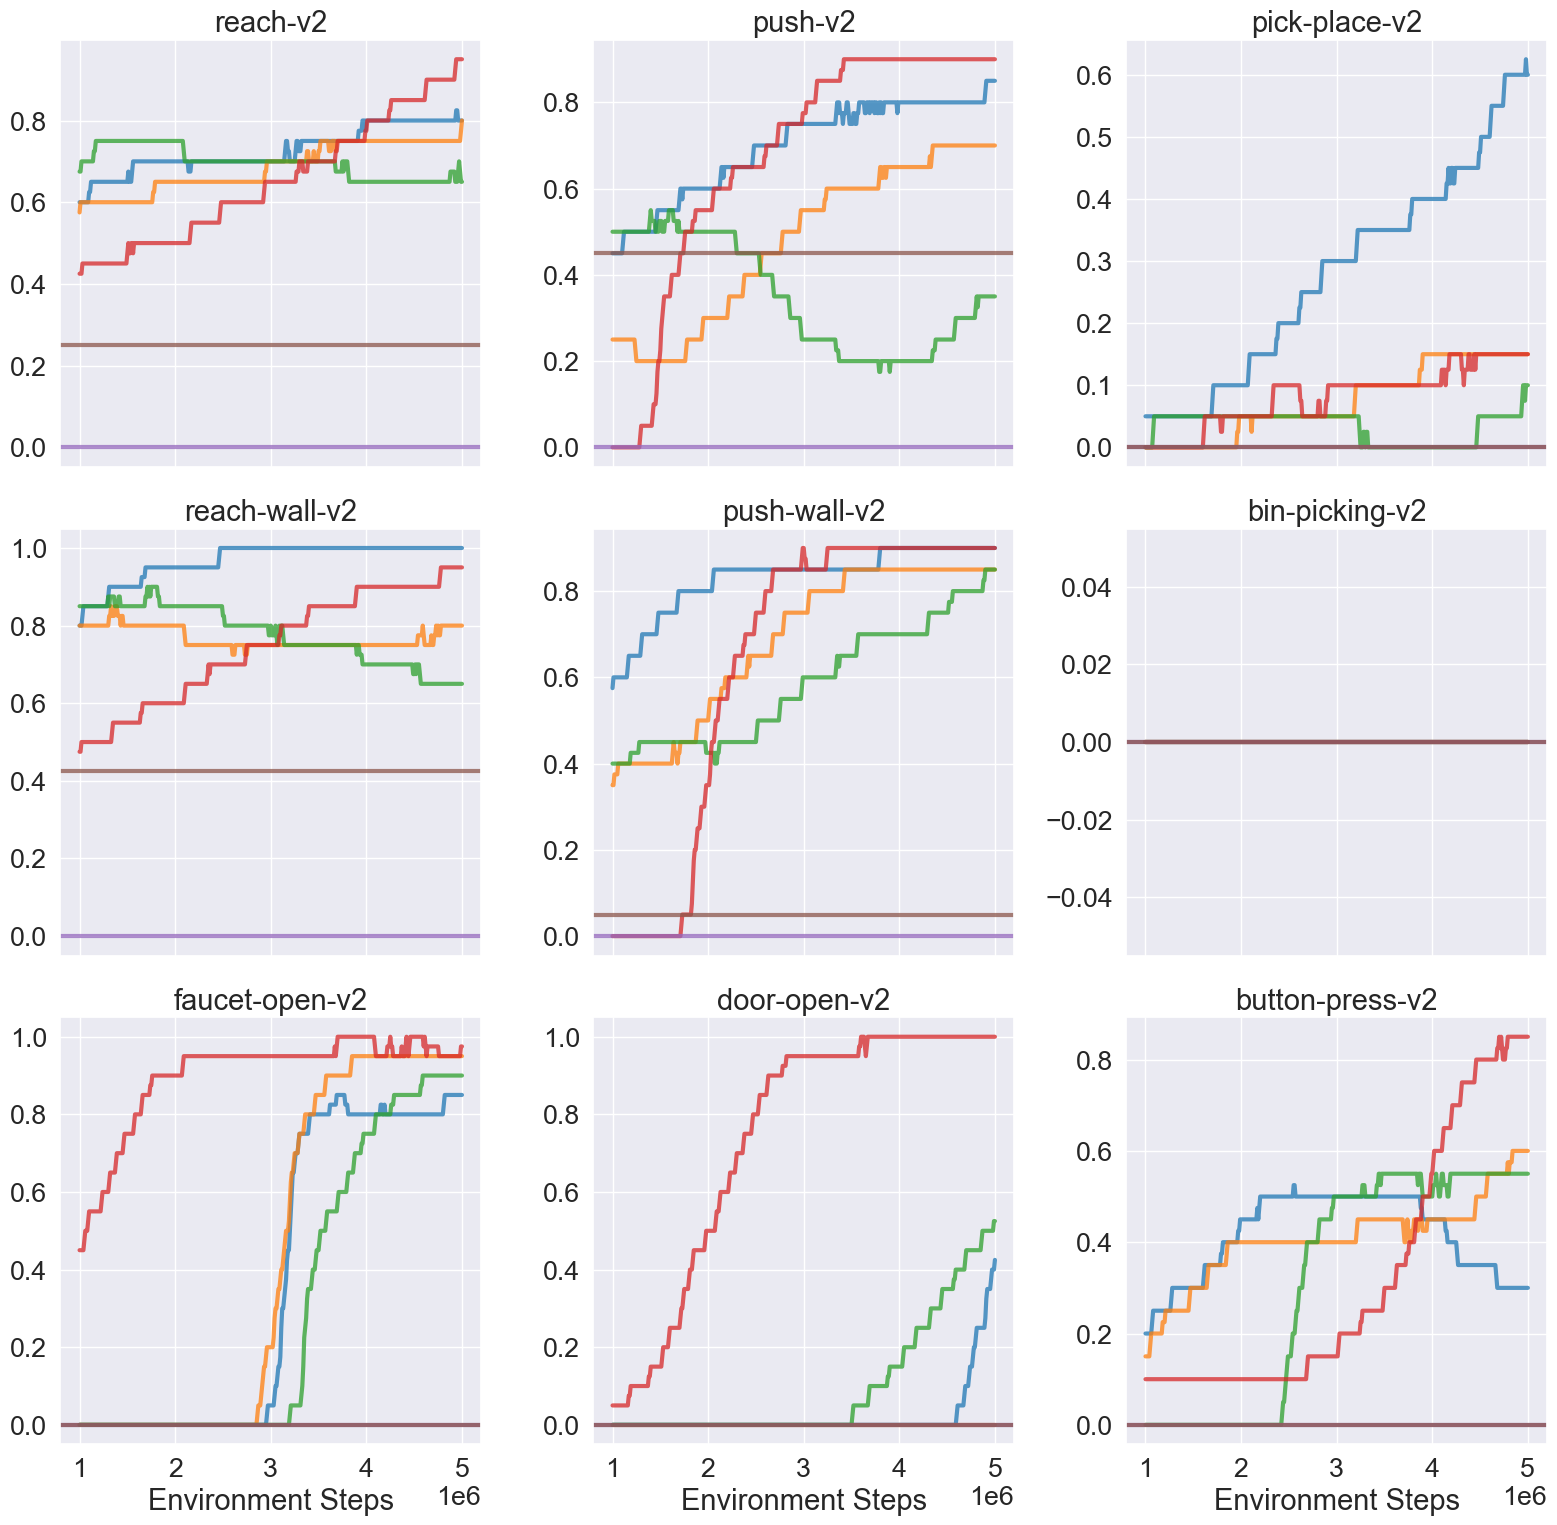

In [67]:
# to_remove = [
#     'right_only_double_params_train', 
#     'right_only_train', 
#     'random_train',
#     'right_only']

plot_reward_trajectory(
    df=train_data,#.query(f'~run_name.isin({TO_REMOVE})'),
    to_remove = TO_REMOVE,
    reward_col='rq_0.1',
    window=WINDOW,
    min_over=MIN_OVER,
    tasks=TRAINING_TASKS,
    figsize=(16,16),
    ylabel='Lowest-decile rewards',
    title=""#'Lowest Decile of Rewards by Task'
)

plot_reward_trajectory(
    df=train_data,#.query(f'~run_name.isin({TO_REMOVE})'),
    to_remove = TO_REMOVE,
    reward_col='reward_mean',
    window=WINDOW,
    min_over=MIN_OVER,
    tasks=TRAINING_TASKS,
    figsize=(16,16),
    ylabel='Mean Rewards',
    title=''#'Mean Rewards by Task'
)

plot_reward_trajectory(
    df=train_data,#.query(f'~run_name.isin({TO_REMOVE})'),
    to_remove = TO_REMOVE,
    reward_col='num_successes',
    window=WINDOW,
    min_over=MIN_OVER,
    tasks=TRAINING_TASKS,
    figsize=(16,16),
    ylabel='Success Rate',
    title=''#'Success Rate by Task'
)

In [68]:
def get_relative_reward(df, reward_col, window, initial = True):
    smoothed = smooth_results_with_median(
        df = df,#train_data.query(f"~run_name.isin({TO_REMOVE})"),
        reward_col = reward_col,
        window = window,
    )
    if initial:
        # take first 1m
        smoothed = (
            smoothed
            .query('frame==1e6')
        )
    else:
        # get minimum median 
        smoothed = (
            smoothed
            .groupby(['training_task', 'run_name'])
            .min()
            .reset_index()
        )

    left = (
        smoothed
        .query('run_name=="left_only_double_params"')
        .rename(columns = {reward_col:f"left_{reward_col}"})
        .drop(['frame', 'run_name'], axis=1)
    )

    bicameral = smoothed.query('run_name.str.contains("bicameral")')

    left_vs_bicameral = (
        bicameral
        .merge(
            left,
            on='training_task'
        )
        .assign(relative_reward=lambda x: x[reward_col] / x[f"left_{reward_col}"])
    )

    return left_vs_bicameral

def plot_heatmap(data, reward_col, window, initial = True):

    relative_rewards = get_relative_reward(data, reward_col, window, initial)
    scaled_heatmap = (
        relative_rewards
        #'\n'.join(my_string.split('('))
        .assign(run_name = lambda x: x.run_name.apply(lambda y: '\n('.join(LABEL_MAPPING[y].split('('))))
        .pivot_table(
            index=['training_task'],
            columns=['run_name'],
            values='relative_reward'
        )
    )

    scaled_heatmap.index = pd.CategoricalIndex(
        scaled_heatmap.index,
        categories=TRAINING_TASKS)
    scaled_heatmap.sort_index(level=0, inplace=True)

    fig, ax = plt.subplots(figsize=(14, 7))
    hmap = sns.heatmap(
        data=scaled_heatmap,
        annot=True,
        annot_kws={'fontsize':21},
        ax=ax,
        vmin=0,
        vmax=2, 
        center=1,
        cmap=sns.color_palette("RdBu", as_cmap=True),
        cbar_kws={'ticks':[0,1,2]}
    )
    ax.set(xlabel=None, ylabel=None)
    ## set label rotation
    loc, labels = plt.xticks()
    hmap.set_xticklabels(labels, rotation=0)
    plt.show();

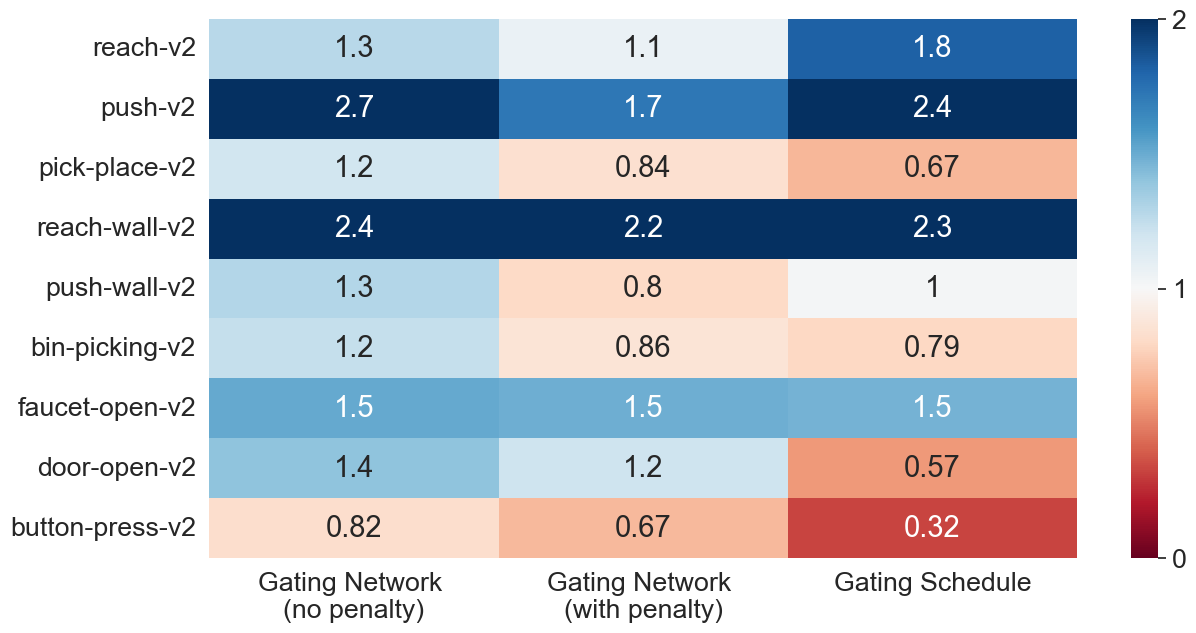

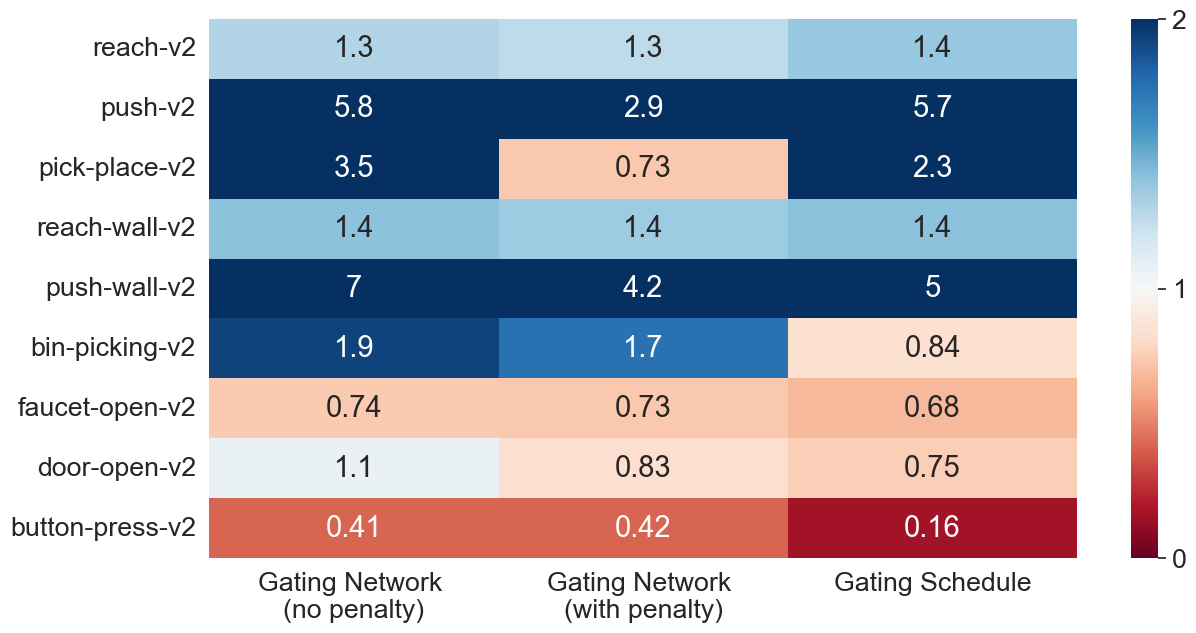

In [69]:
## initial
## lowest decile
plot_heatmap(
    train_data.query(f"~run_name.isin({TO_REMOVE})"),
    reward_col = 'rq_0.1',
    window=WINDOW,
    initial=True
)

## mean rewards
plot_heatmap(
    train_data.query(f"~run_name.isin({TO_REMOVE})"),
    reward_col = 'reward_mean',
    window=WINDOW,
    initial=True
)

In [70]:
my_string ='Gating Network (no penalty)'
'\n('.join(my_string.split('('))

'Gating Network \n(no penalty)'

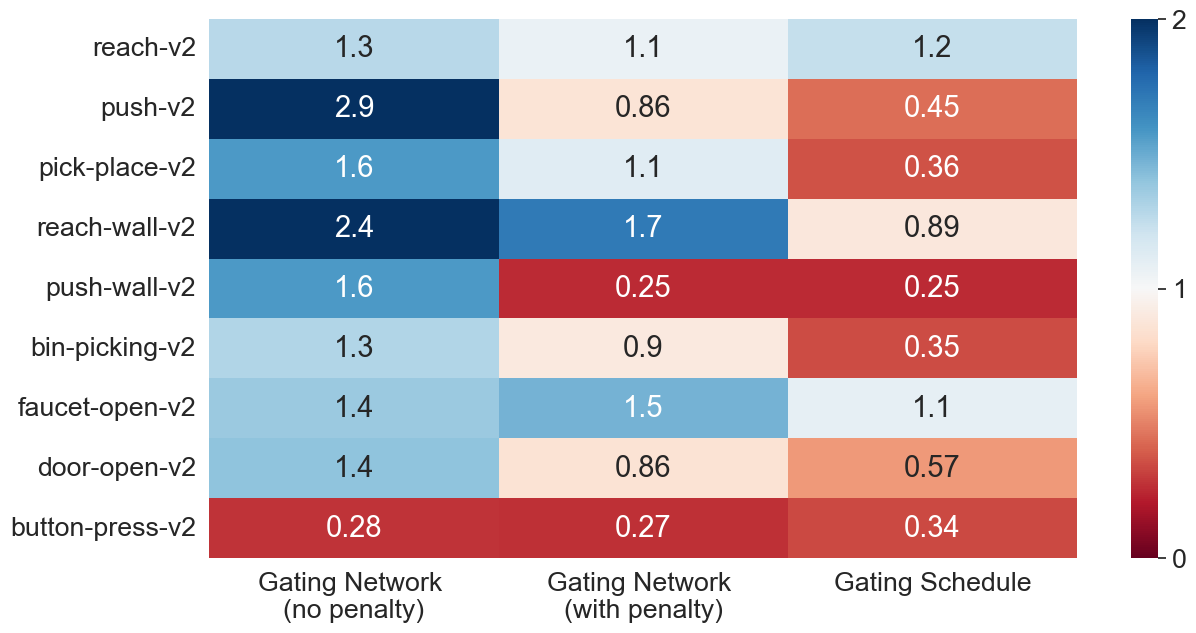

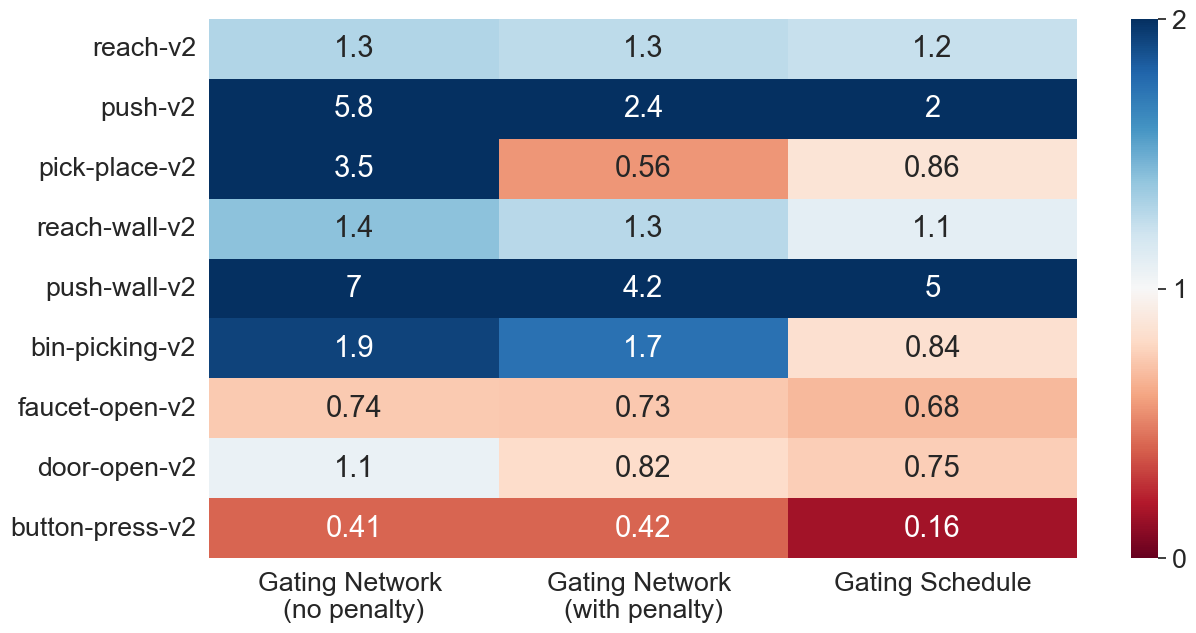

In [71]:
## overall
## lowest decile
plot_heatmap(
    train_data.query(f"~run_name.isin({TO_REMOVE})"),
    reward_col = 'rq_0.1',
    window=WINDOW,
    initial=False
)

## mean rewards
plot_heatmap(
    train_data.query(f"~run_name.isin({TO_REMOVE})"),
    reward_col = 'reward_mean',
    window=WINDOW,
    initial=False
)

In [72]:
def get_left_only_vs_relative(train_data, left_eval_data, test_data, relative_reward_col, left_only_reward_col, initial=True):

    relative_rewards = get_relative_reward(
        df=train_data,#train_data.query(f"~run_name.isin({TO_REMOVE})"),
        reward_col=relative_reward_col, 
        window=WINDOW, 
        initial=initial).drop('frame', axis=1)

    hem_vs_baseline = (
        pd.merge(
            left_eval_data,
            (
                test_data
                .query('run_name == "left_only_double_params"')
                .loc[:,['frame','training_task','reward_mean']]
                .rename(columns={left_only_reward_col:f'left_{left_only_reward_col}'})
            ),
            on=['frame','training_task']
        )
        .query('frame > 4e6') # parametrize?
        .loc[:, ['training_task', 'run_name', left_only_reward_col,f'left_{left_only_reward_col}']]
        .groupby(['training_task', 'run_name'])
        .median()
        .assign(**{f"left_hemisphere_{left_only_reward_col}":lambda x: x[left_only_reward_col] / x[f'left_{left_only_reward_col}']})
        .reset_index()
        .loc[:, ['training_task','run_name', 'left_hemisphere_reward_mean']]
    )

    combined = (
        hem_vs_baseline
        .merge(relative_rewards, on=['training_task','run_name'])
        )

    return combined

def plot_left_only_vs_relative(
    train_data, left_eval_data, test_data, relative_reward_col, left_only_reward_col, 
    initial, xlabel, ylabel, figsize=(14,7)
    ):
    
    combined = get_left_only_vs_relative(
        train_data, 
        left_eval_data, 
        test_data, 
        relative_reward_col, 
        left_only_reward_col,
        initial=initial)

    fig, ax = plt.subplots(1,3,figsize=figsize, sharex=True, sharey=True)
    ax = ax.flatten()

    for i, alg in enumerate(np.unique(combined.run_name)):
        sns.scatterplot(
            data=combined.query(f'run_name=="{alg}"'),
            x='left_hemisphere_reward_mean',
            y = 'relative_reward',
            hue='training_task',
            palette=TASK_PALETTE,
            s=350,
            alpha=0.75,
            ax = ax[i]
        )
        ax[i].set(title=LABEL_MAPPING[alg], xlabel=xlabel, ylabel=ylabel)
        ax[i].axhline(1, c='black')
        ax[i].axvline(1, c='black')
        ax[i].get_legend().remove()

    plt.tight_layout()
    plt.show()


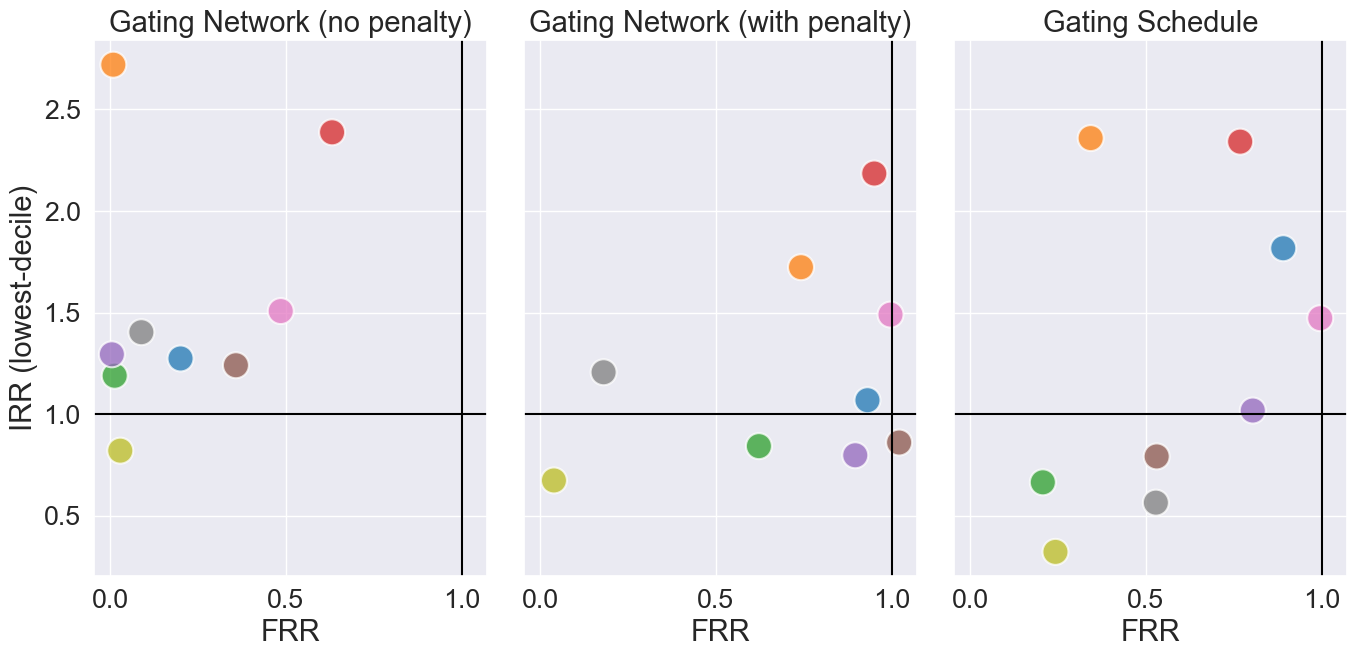

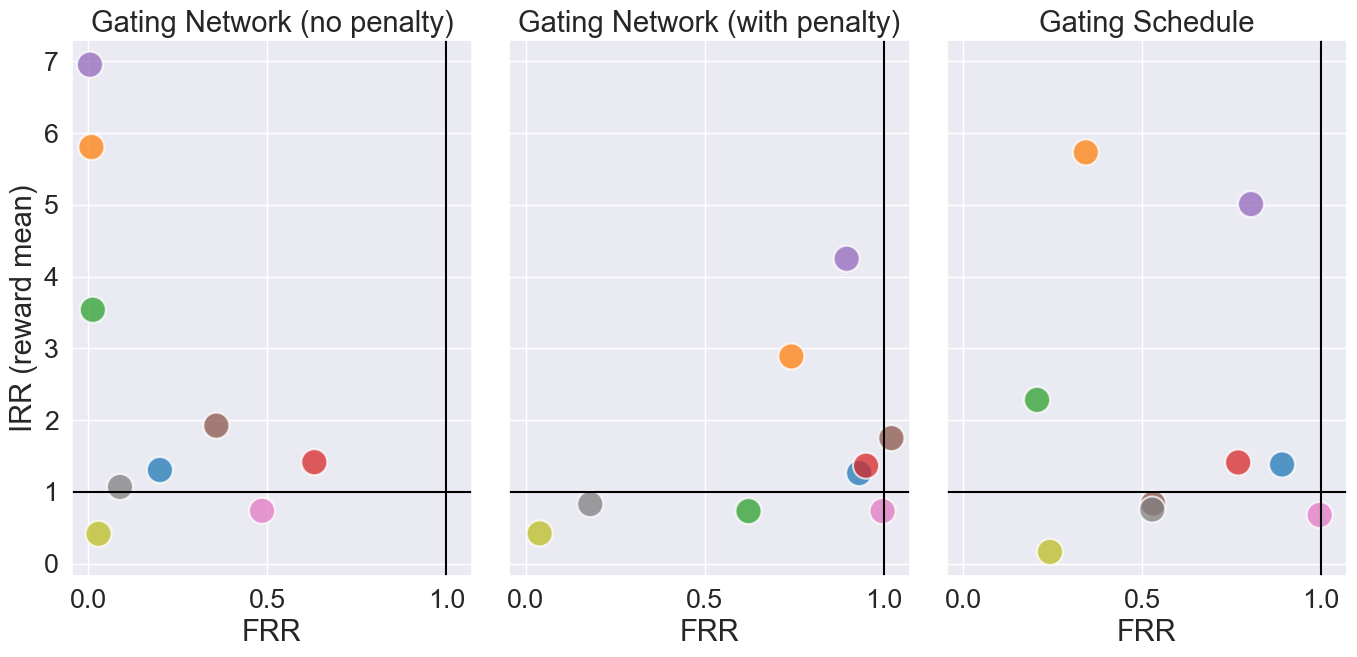

In [73]:
# initial

## lowest decile
plot_left_only_vs_relative(
    train_data = train_data.query(f"~run_name.isin({TO_REMOVE})"), 
    left_eval_data=left_eval_data, 
    test_data=test_data, 
    relative_reward_col='rq_0.1', 
    left_only_reward_col='reward_mean', 
    initial=True, 
    xlabel="FRR", 
    ylabel="IRR (lowest-decile)", 
    figsize=(14,7)
    )

## reward mean
plot_left_only_vs_relative(
    train_data = train_data.query(f"~run_name.isin({TO_REMOVE})"), 
    left_eval_data=left_eval_data, 
    test_data=test_data, 
    relative_reward_col='reward_mean', 
    left_only_reward_col='reward_mean', 
    initial=True, 
    xlabel="FRR", 
    ylabel="IRR (reward mean)", 
    figsize=(14,7)
    )

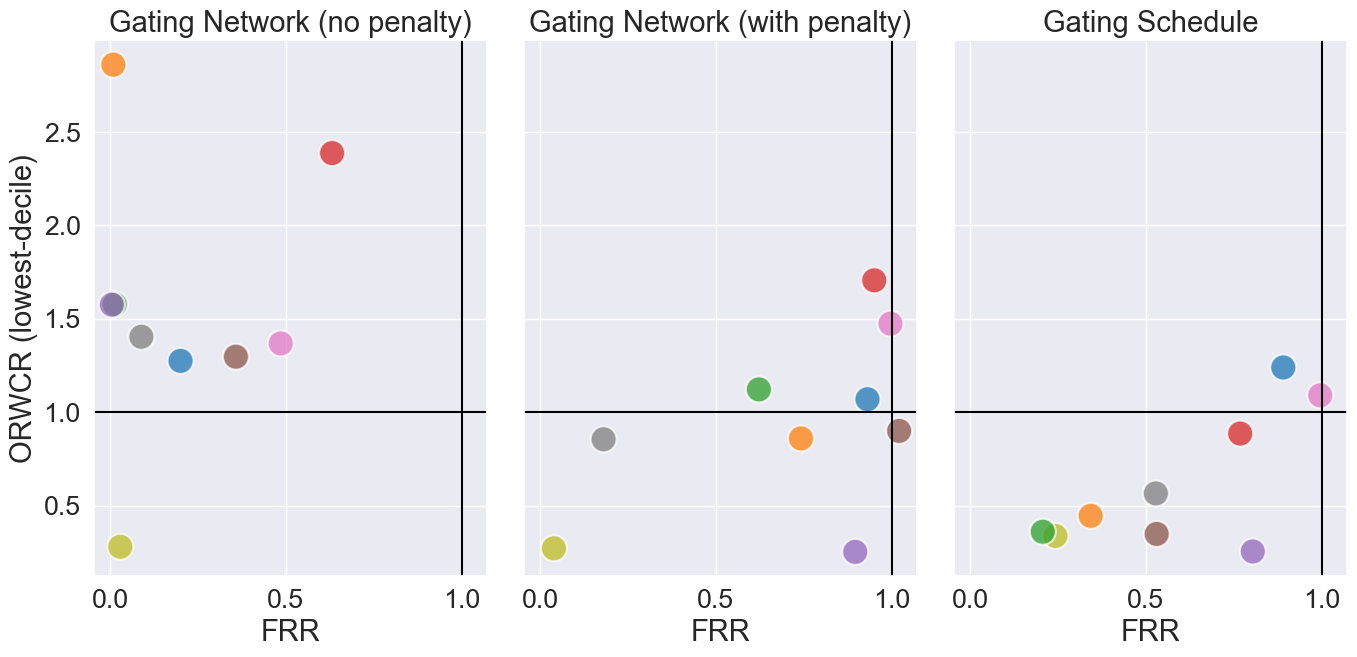

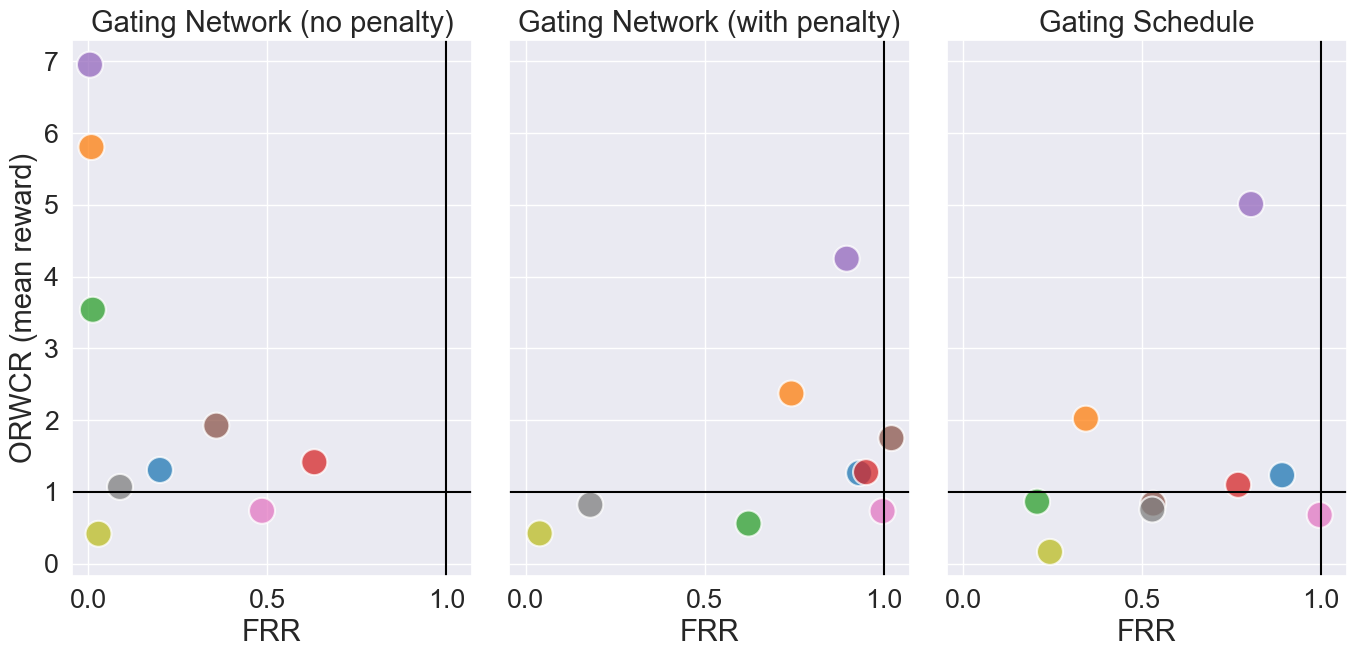

In [74]:
# overall

## lowest decile
plot_left_only_vs_relative(
    train_data = train_data.query(f"~run_name.isin({TO_REMOVE})"), 
    left_eval_data=left_eval_data, 
    test_data=test_data, 
    relative_reward_col='rq_0.1', 
    left_only_reward_col='reward_mean', 
    initial=False, 
    xlabel="FRR", 
    ylabel="ORWCR (lowest-decile)", 
    figsize=(14,7)
    )

## reward mean
plot_left_only_vs_relative(
    train_data = train_data.query(f"~run_name.isin({TO_REMOVE})"), 
    left_eval_data=left_eval_data, 
    test_data=test_data, 
    relative_reward_col='reward_mean', 
    left_only_reward_col='reward_mean', 
    initial=False, 
    xlabel="FRR", 
    ylabel="ORWCR (mean reward)", 
    figsize=(14,7)
    )

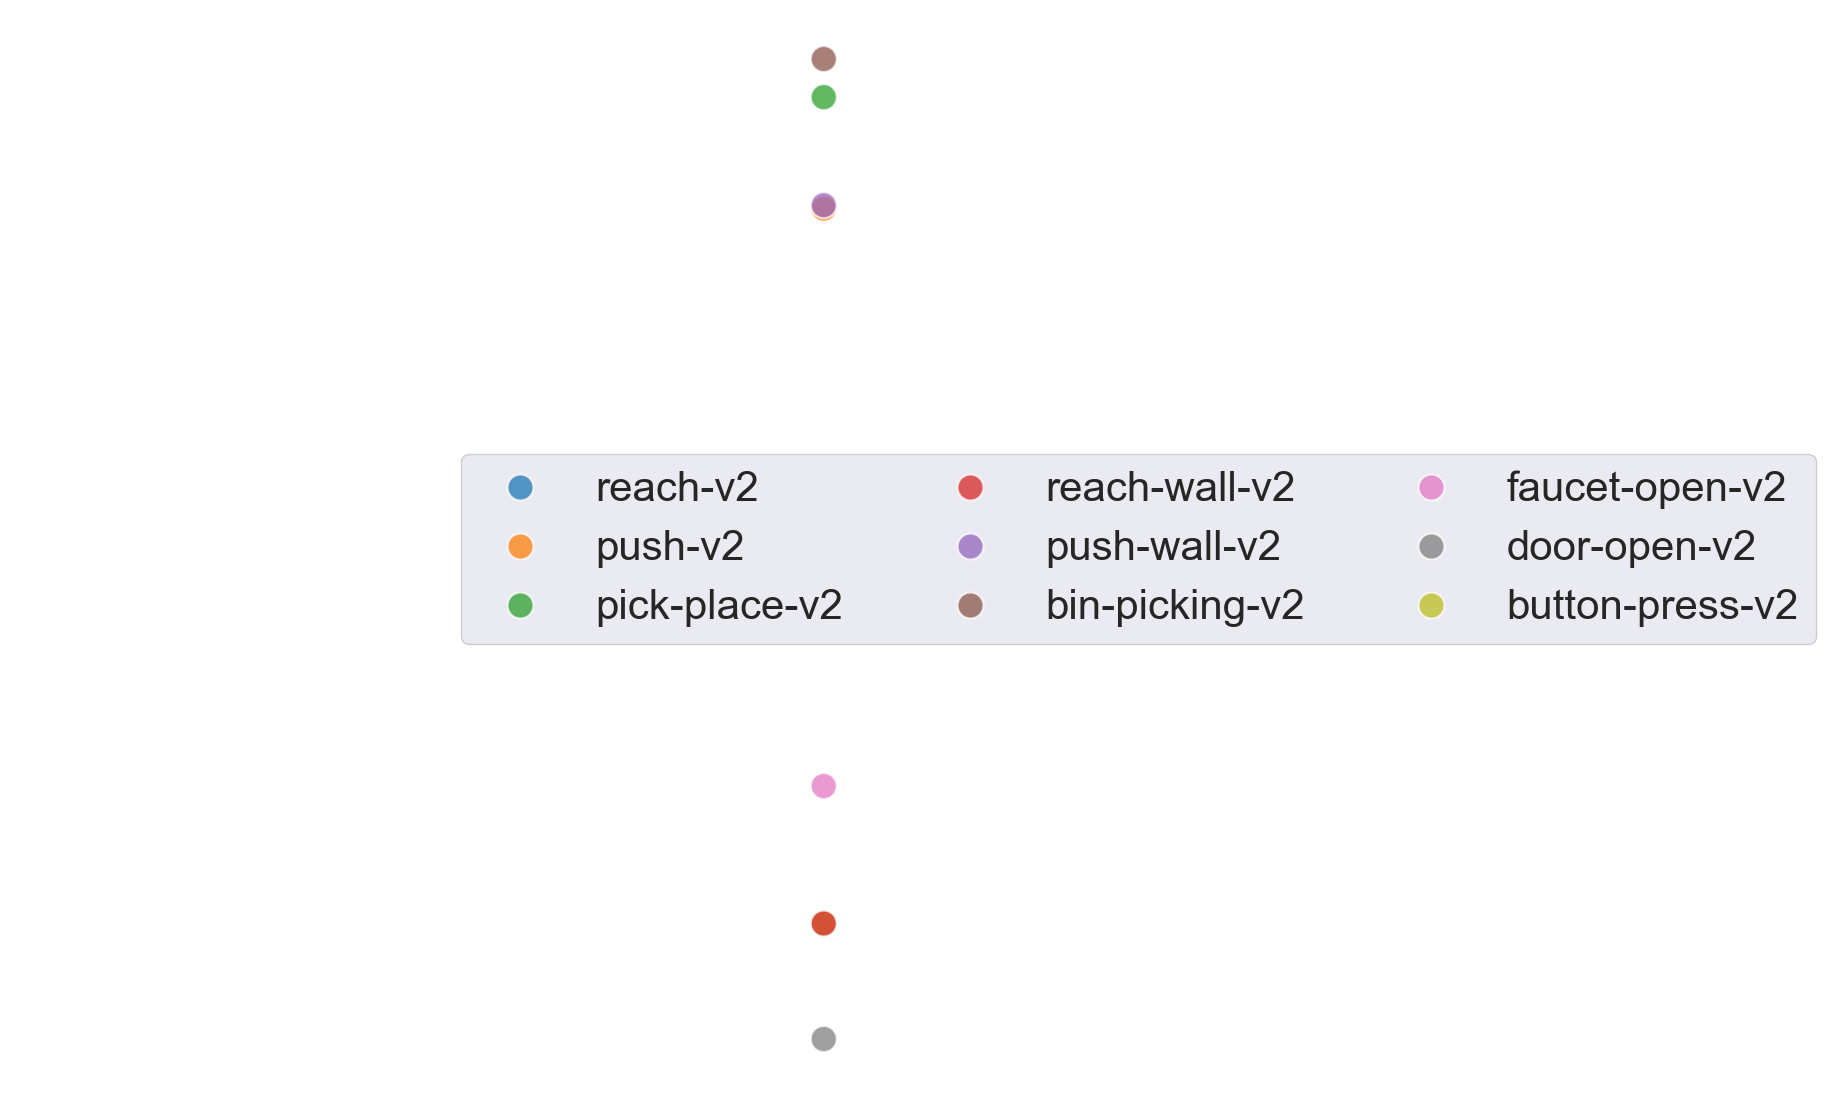

In [75]:
### dummy task legend
df = train_data.loc[:,['training_task', 'reward_mean', 'gq_0.5']].groupby('training_task').mean()
df.loc[:,'reward_mean'] *= 0
df.loc[:,'gq_0.5'] *= 100

fig, ax = plt.subplots(figsize=(21, 14))
sns.scatterplot(
    data=df,
    x='reward_mean',
    y='gq_0.5',
    hue='training_task',
    palette=TASK_PALETTE,
    s=350,
    alpha=0.75,
)
plt.axis('off')
handles, labels = plt.gca().get_legend_handles_labels()
label2idx = {lab:i for i, lab in enumerate(labels)}
label_order = [label2idx[task] for task in TRAINING_TASKS]

fig.legend(
    [handles[idx] for idx in label_order], 
    [labels[idx] for idx in label_order], 
    loc = 'right',
    fontsize='x-large', 
    title_fontsize='40',  
    ncol=3,
    framealpha=1)

ax.get_legend().remove()
plt.show()

In [76]:
right_baseline = (
    train_data
    .query('run_name=="right_only_double_params"')
    .loc[:,['run_name','training_task', 'reward_mean']]
    .groupby(['training_task', 'run_name'])
    .median()
    .reset_index()
)

left_only_test = (
    test_data
    .query('run_name=="left_only_double_params"')
    .loc[:,['training_task', 'frame', 'run_name','reward_mean']]
    .query('frame >= 4e6')
    .groupby(['run_name', 'training_task'])
    .median()
    .reset_index()
    .loc[:,['run_name', 'training_task', 'reward_mean']]
    .rename(columns={'reward_mean':'left_reward_mean'})
    .drop('run_name', axis=1)
)

left_hem_test = (
    left_eval_data
    .loc[:,['training_task', 'frame', 'run_name','reward_mean']]
    .query('frame >= 4e6')
    .groupby(['run_name', 'training_task'])
    .median()
    .reset_index()
    .loc[:,['run_name', 'training_task', 'reward_mean']]
)

combined = (
    pd.merge(
        pd.concat([left_hem_test,right_baseline]), 
        left_only_test,
        on = [ 'training_task']
    )
    .assign(relative_reward = lambda x: x.reward_mean / x.left_reward_mean)
)

combined.index = pd.CategoricalIndex(
    combined.training_task,
    categories=TRAINING_TASKS)
combined.sort_index(level=0, inplace=True)



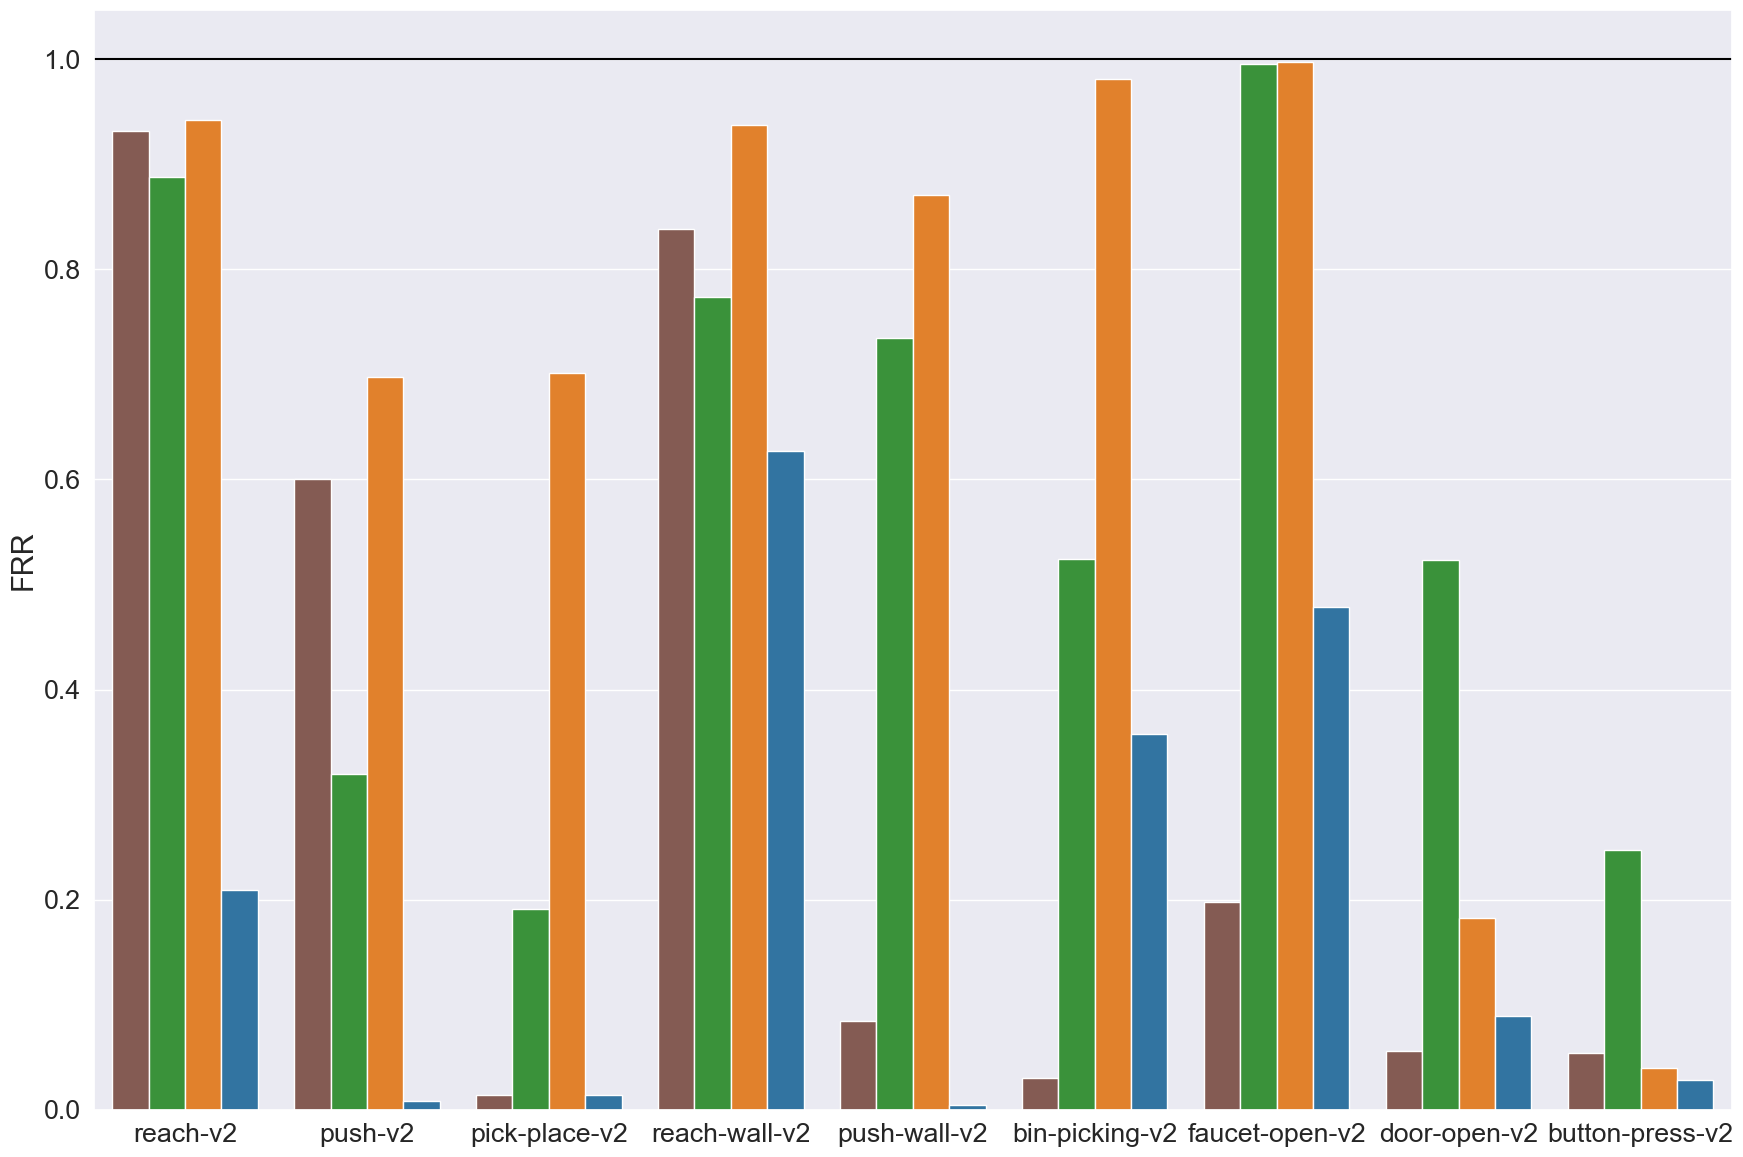

In [77]:
fig, ax = plt.subplots(figsize=(18,12))
sns.barplot(
    data=combined,
    x='training_task',
    y='relative_reward',
    hue='run_name',
    ax=ax,
    palette=PALETTE
)
ax.axhline(1, c='black')
ax.set_ylabel("FRR")
ax.set_xlabel(None)
ax.get_legend().remove()

## legend stuff
# handles, labels = plt.gca().get_legend_handles_labels()


# fig.legend(
#     handles, 
#     [LABEL_MAPPING[label] for label in labels], 
#     loc = 'right',
#     fontsize='x-large', 
#     title_fontsize='40',  
#     ncol=3,
#     framealpha=1)

plt.tight_layout()
plt.show();

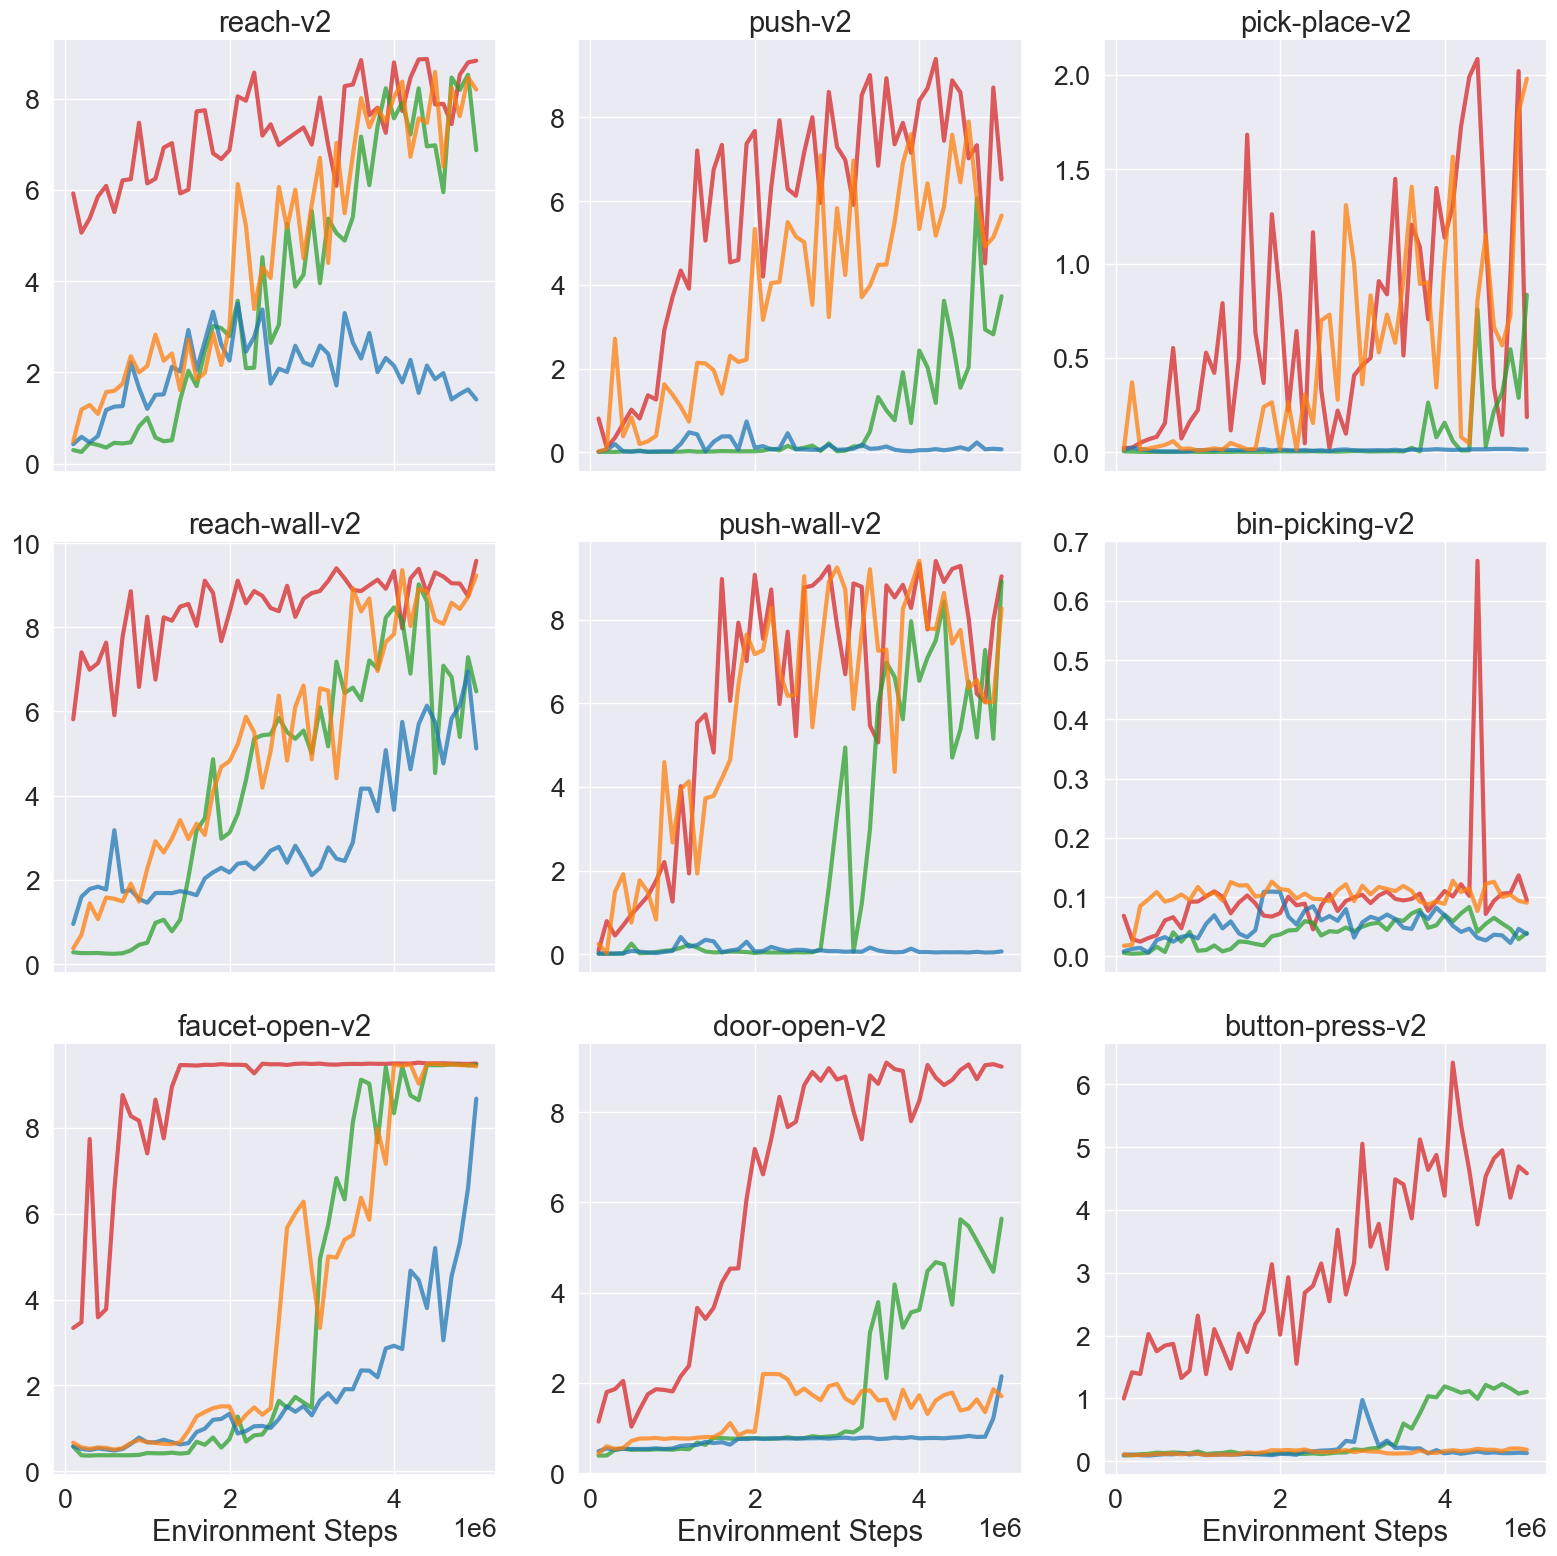

In [78]:
left_to_test = pd.concat([test_data.query('run_name=="left_only_double_params"'), left_eval_data])
fig, ax = plt.subplots(3,3,figsize=(16,16), sharex=True)
ax = ax.flatten()
for i, task in enumerate(TRAINING_TASKS):

    sns.lineplot(
        data=left_to_test.query(f"training_task=='{task}'"),
        x = 'frame',
        y = 'reward_mean',
        hue='run_name',
        ax = ax[i],
        palette=PALETTE,
        alpha = .75,
        linewidth=3
    )

    ax[i].set(title=task, ylabel=None, xlabel='Environment Steps')
    ax[i].get_legend().remove()

plt.tight_layout()
plt.show();

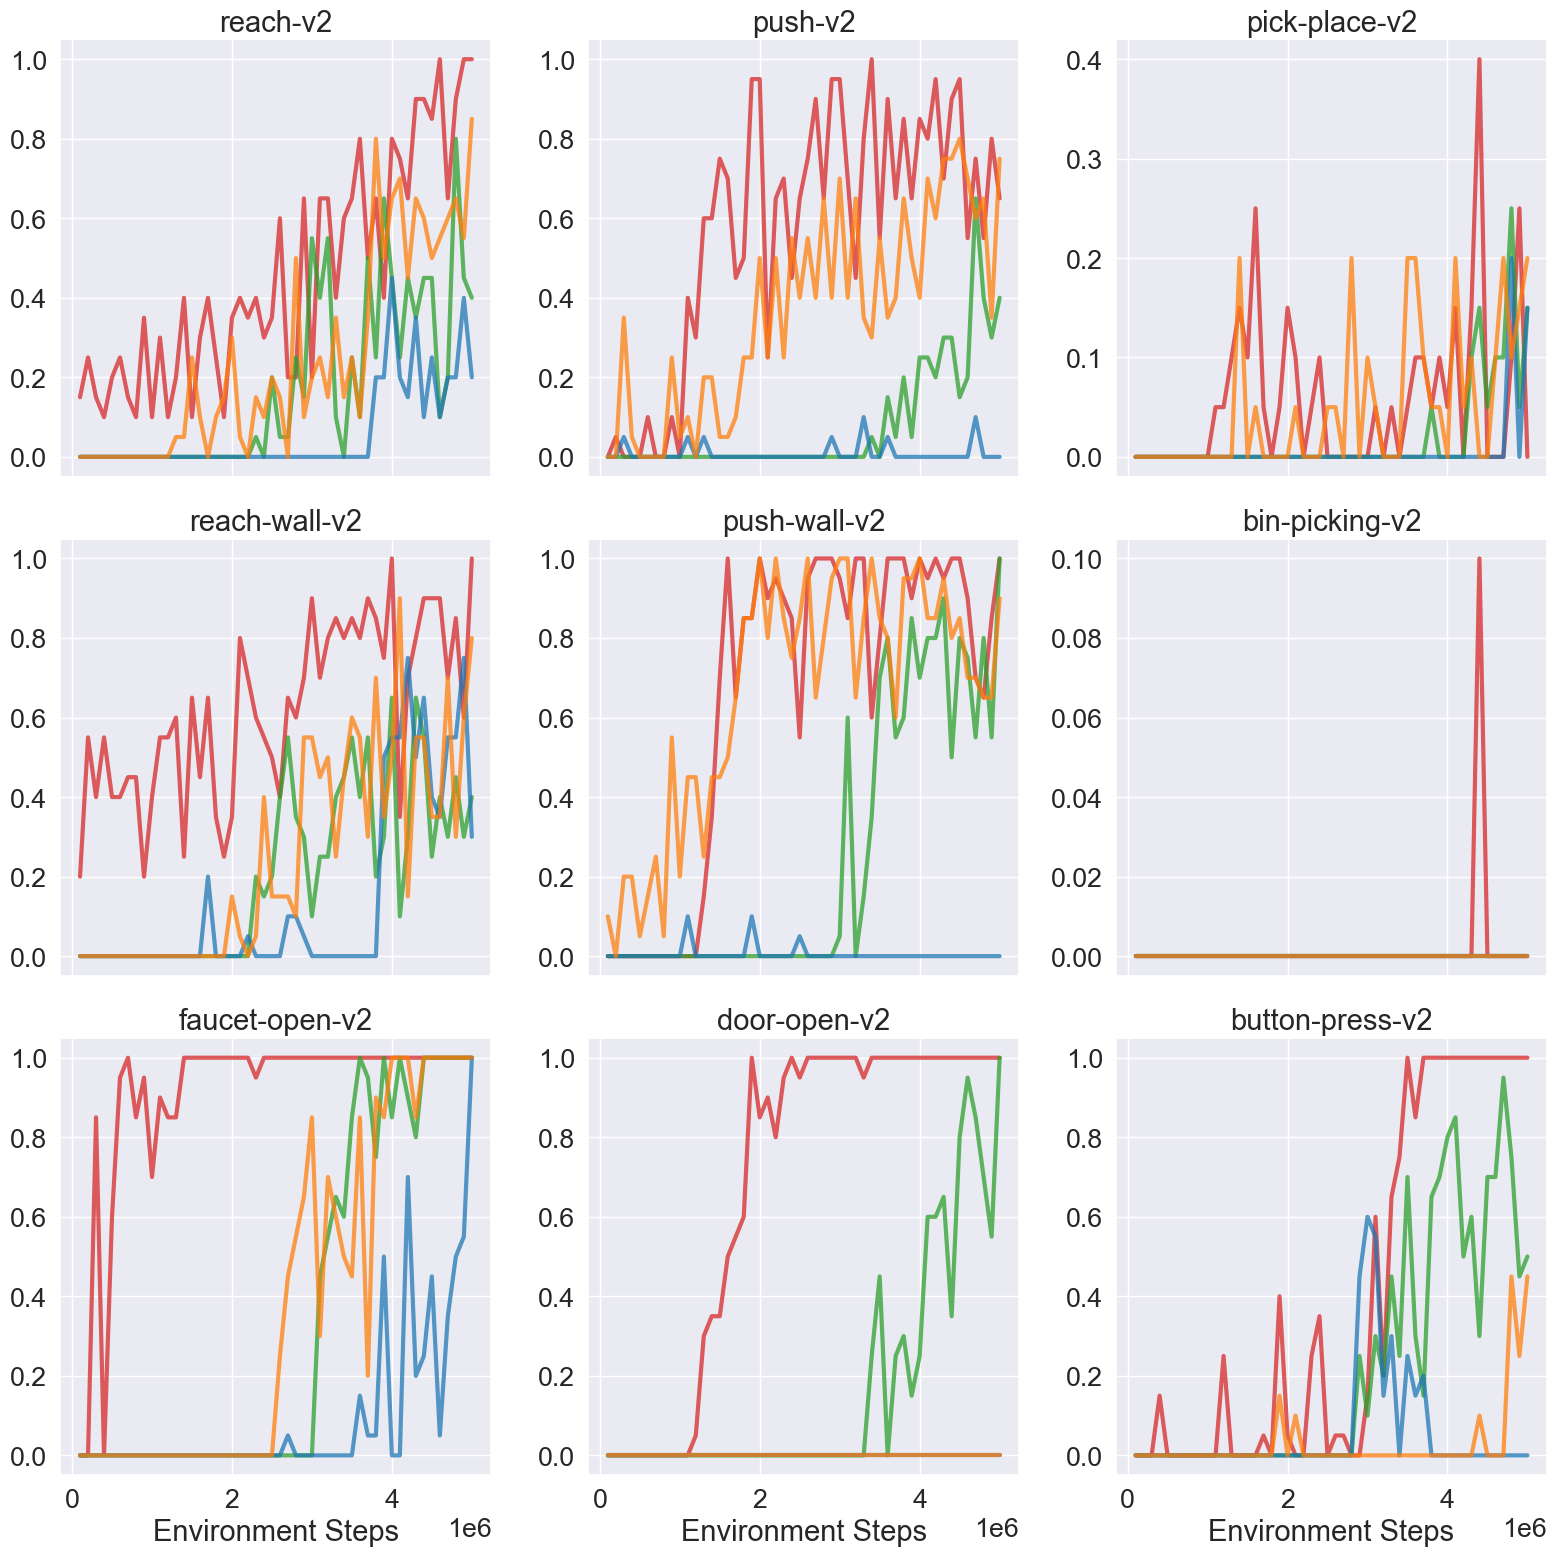

In [79]:
left_to_test = pd.concat([test_data.query('run_name=="left_only_double_params"'), left_eval_data])
fig, ax = plt.subplots(3,3,figsize=(16,16), sharex=True)
ax = ax.flatten()
for i, task in enumerate(TRAINING_TASKS):

    sns.lineplot(
        data=left_to_test.query(f"training_task=='{task}'"),
        x = 'frame',
        y = 'num_successes',
        hue='run_name',
        ax = ax[i],
        palette=PALETTE,
        alpha = .75,
        linewidth=3
    )

    ax[i].set(title=task, ylabel=None, xlabel='Environment Steps')
    ax[i].get_legend().remove()

plt.tight_layout()
plt.show();

In [80]:
to_plot = (
    left_vs_initial
    .merge(
        (
            cumulative_res
            .loc[:,['training_task', 'run_name', 'pct_reward_diff']]
        ), 
        on =['training_task', 'run_name'])
)

algorithms = np.unique(left_vs_initial.run_name)
    # hard code grid (1,3) depends on num algorithms
fig, ax = plt.subplots(1,3,figsize=(21, 10), sharex=True, sharey=True)
ax = ax.flatten()

# plt.suptitle("blah")

for i, alg in enumerate(algorithms):

    sns.scatterplot(
        data=to_plot.query(f'run_name=="{alg}"'),
        x=f'left_hemisphere_reward_mean',
        y=f'pct_reward_diff',
        hue='training_task',
        style='tier',
        palette=TASK_PALETTE,
        ax = ax[i],
        s=200
    )

    if i > 0:
        ax[i].get_legend().remove()

    ax[i].set_title(alg)
    # if xlabel is not None:
    #     ax[i].set_xlabel(xlabel)
    # if ylabel is not None:
    #     ax[i].set_ylabel(ylabel)
    ax[i].axhline(0, c='black')
    ax[i].axvline(1, c='black')
    # ax[i].axvline(.5, c='black', alpha=0.5)

plt.tight_layout()
plt.show();

NameError: name 'left_vs_initial' is not defined

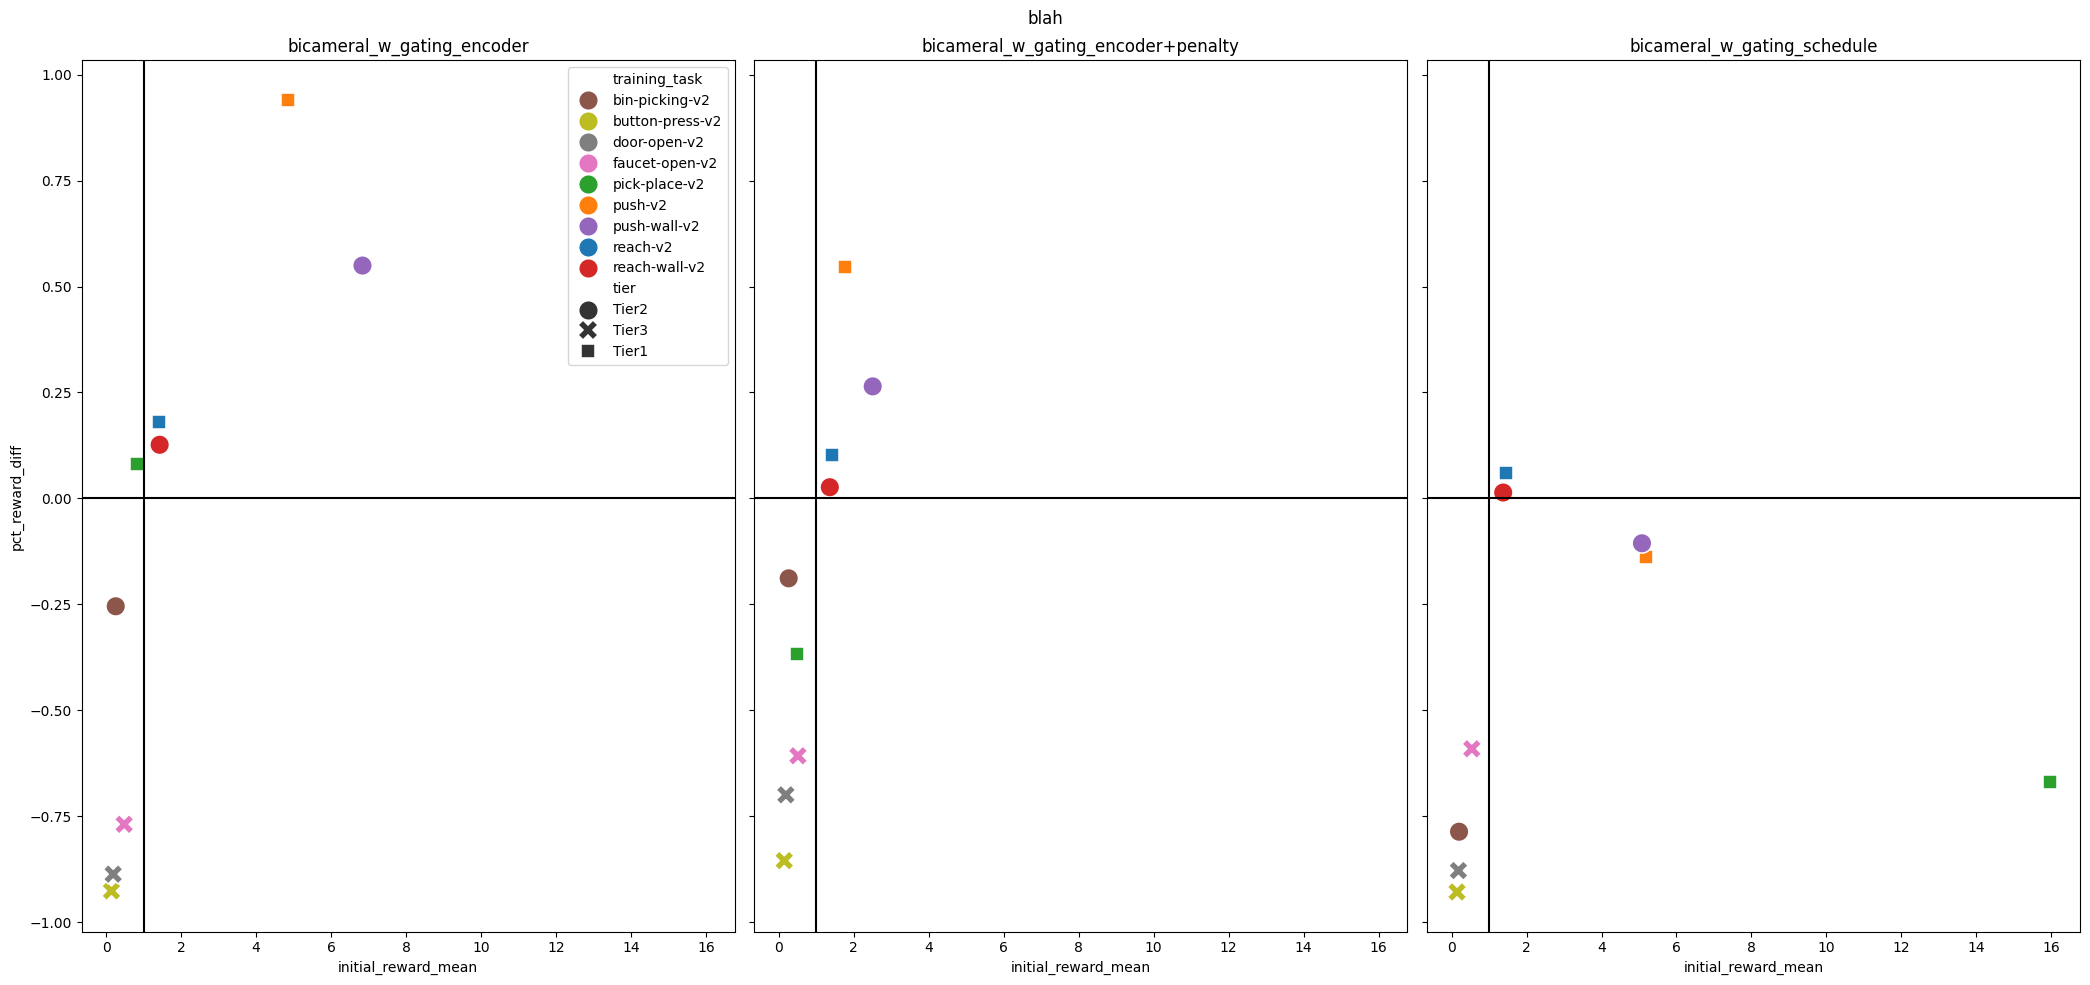

In [ ]:
to_plot = (
    left_vs_initial
    .merge(
        (
            cumulative_res
            .loc[:,['training_task', 'run_name', 'pct_reward_diff']]
        ), 
        on =['training_task', 'run_name'])
)

algorithms = np.unique(left_vs_initial.run_name)
    # hard code grid (1,3) depends on num algorithms
fig, ax = plt.subplots(1,3,figsize=(21, 10), sharex=True, sharey=True)
ax = ax.flatten()

plt.suptitle("blah")

for i, alg in enumerate(algorithms):

    sns.scatterplot(
        data=to_plot.query(f'run_name=="{alg}"'),
        x=f'initial_reward_mean',
        y=f'pct_reward_diff',
        hue='training_task',
        style='tier',
        palette=TASK_PALETTE,
        ax = ax[i],
        s=200
    )

    if i > 0:
        ax[i].get_legend().remove()

    ax[i].set_title(alg)
    # if xlabel is not None:
    #     ax[i].set_xlabel(xlabel)
    # if ylabel is not None:
    #     ax[i].set_ylabel(ylabel)
    ax[i].axhline(0, c='black')
    ax[i].axvline(1, c='black')
    # ax[i].axvline(.5, c='black', alpha=0.5)

plt.tight_layout()
plt.show();

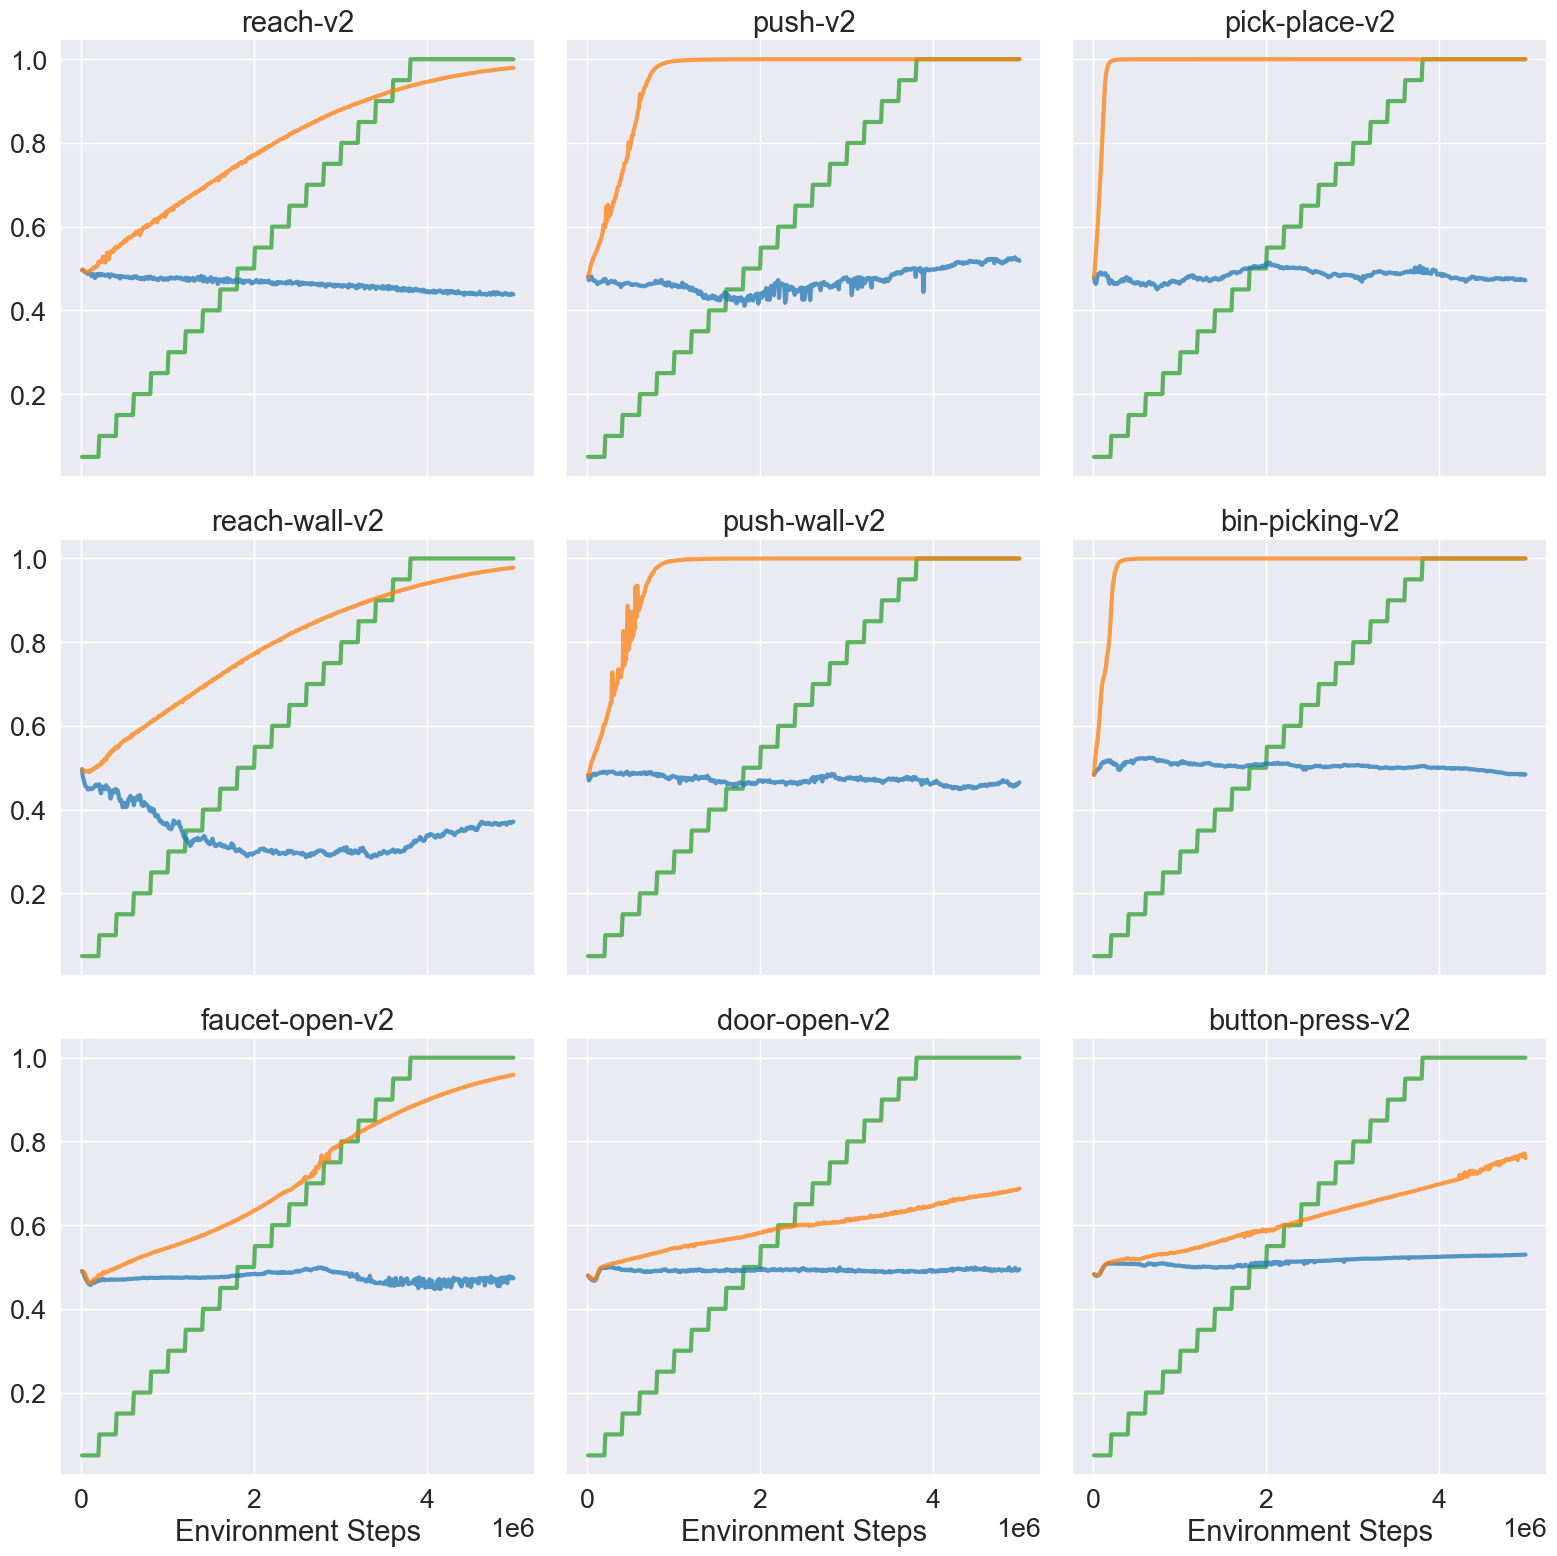

In [83]:

to_remove_gate = TO_REMOVE + ['left_only_double_params', 'right_only_double_params']

to_plot = (
    train_data
    .query(f'~run_name.isin({to_remove_gate})')
)

fig, ax = plt.subplots(3,3,figsize=(16,16), sharex = True, sharey=True)
ax = ax.flatten()

for i, task in enumerate(TRAINING_TASKS):

    sns.lineplot(
        data = to_plot.query(f'training_task=="{task}"'),
        x='frame',
        y='gq_0.5',
        hue='run_name',
        ax = ax[i],
        palette=PALETTE,
        alpha = 0.75,
        linewidth=3
    )

    ax[i].get_legend().remove()
        
    ax[i].set_title(task)
    ax[i].set(ylabel='', xlabel='Environment Steps')

plt.tight_layout()
plt.show();

In [81]:
## simulated data
data = np.linspace(0.01,0.99, 1000)
penalty = np.vectorize(lambda alpha, beta, x: beta * (x / (1-x))**alpha)

alphas = [0.5, 0.75, 1]
beta = 5
penalised_values = dict()
for alpha in alphas:
    penalised_values[alpha] = penalty(alpha, beta, data)


penalty_data = (
    pd.DataFrame(penalised_values, index=data)
    .reset_index()
    .melt(
        id_vars='index',
        var_name='alpha',
        value_name='penalty'
        )
)

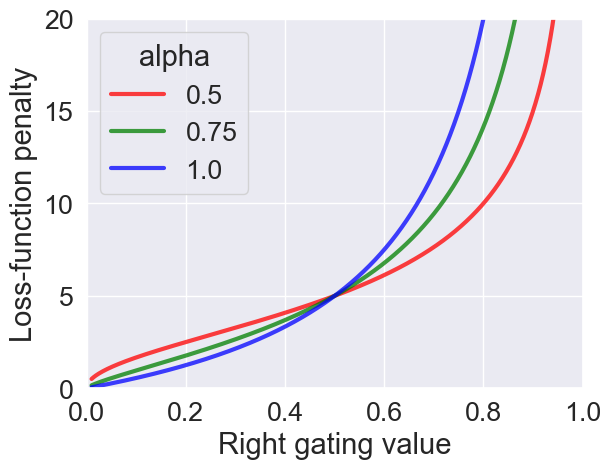

In [82]:
from matplotlib.colors import ListedColormap

# Create a colormap with three colors: red, green, blue
cmap = ListedColormap(['red', 'green', 'blue'])

sns.lineplot(
    data = penalty_data,
    x = 'index',
    y = 'penalty',
    hue = 'alpha',
    palette=cmap,
    alpha=0.75,
    linewidth=3
)
plt.xlim(0, 1)
plt.ylim(0, 20)
plt.xlabel('Right gating value')
plt.ylabel('Loss-function penalty')
plt.show();

## 2. Get RL2 meta-train / test results


C:\Users\61417\AppData\Local\Temp\ipykernel_51736\3105394730.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_51736\3105394730.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_51736\3105394730.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_51736\3105394730.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

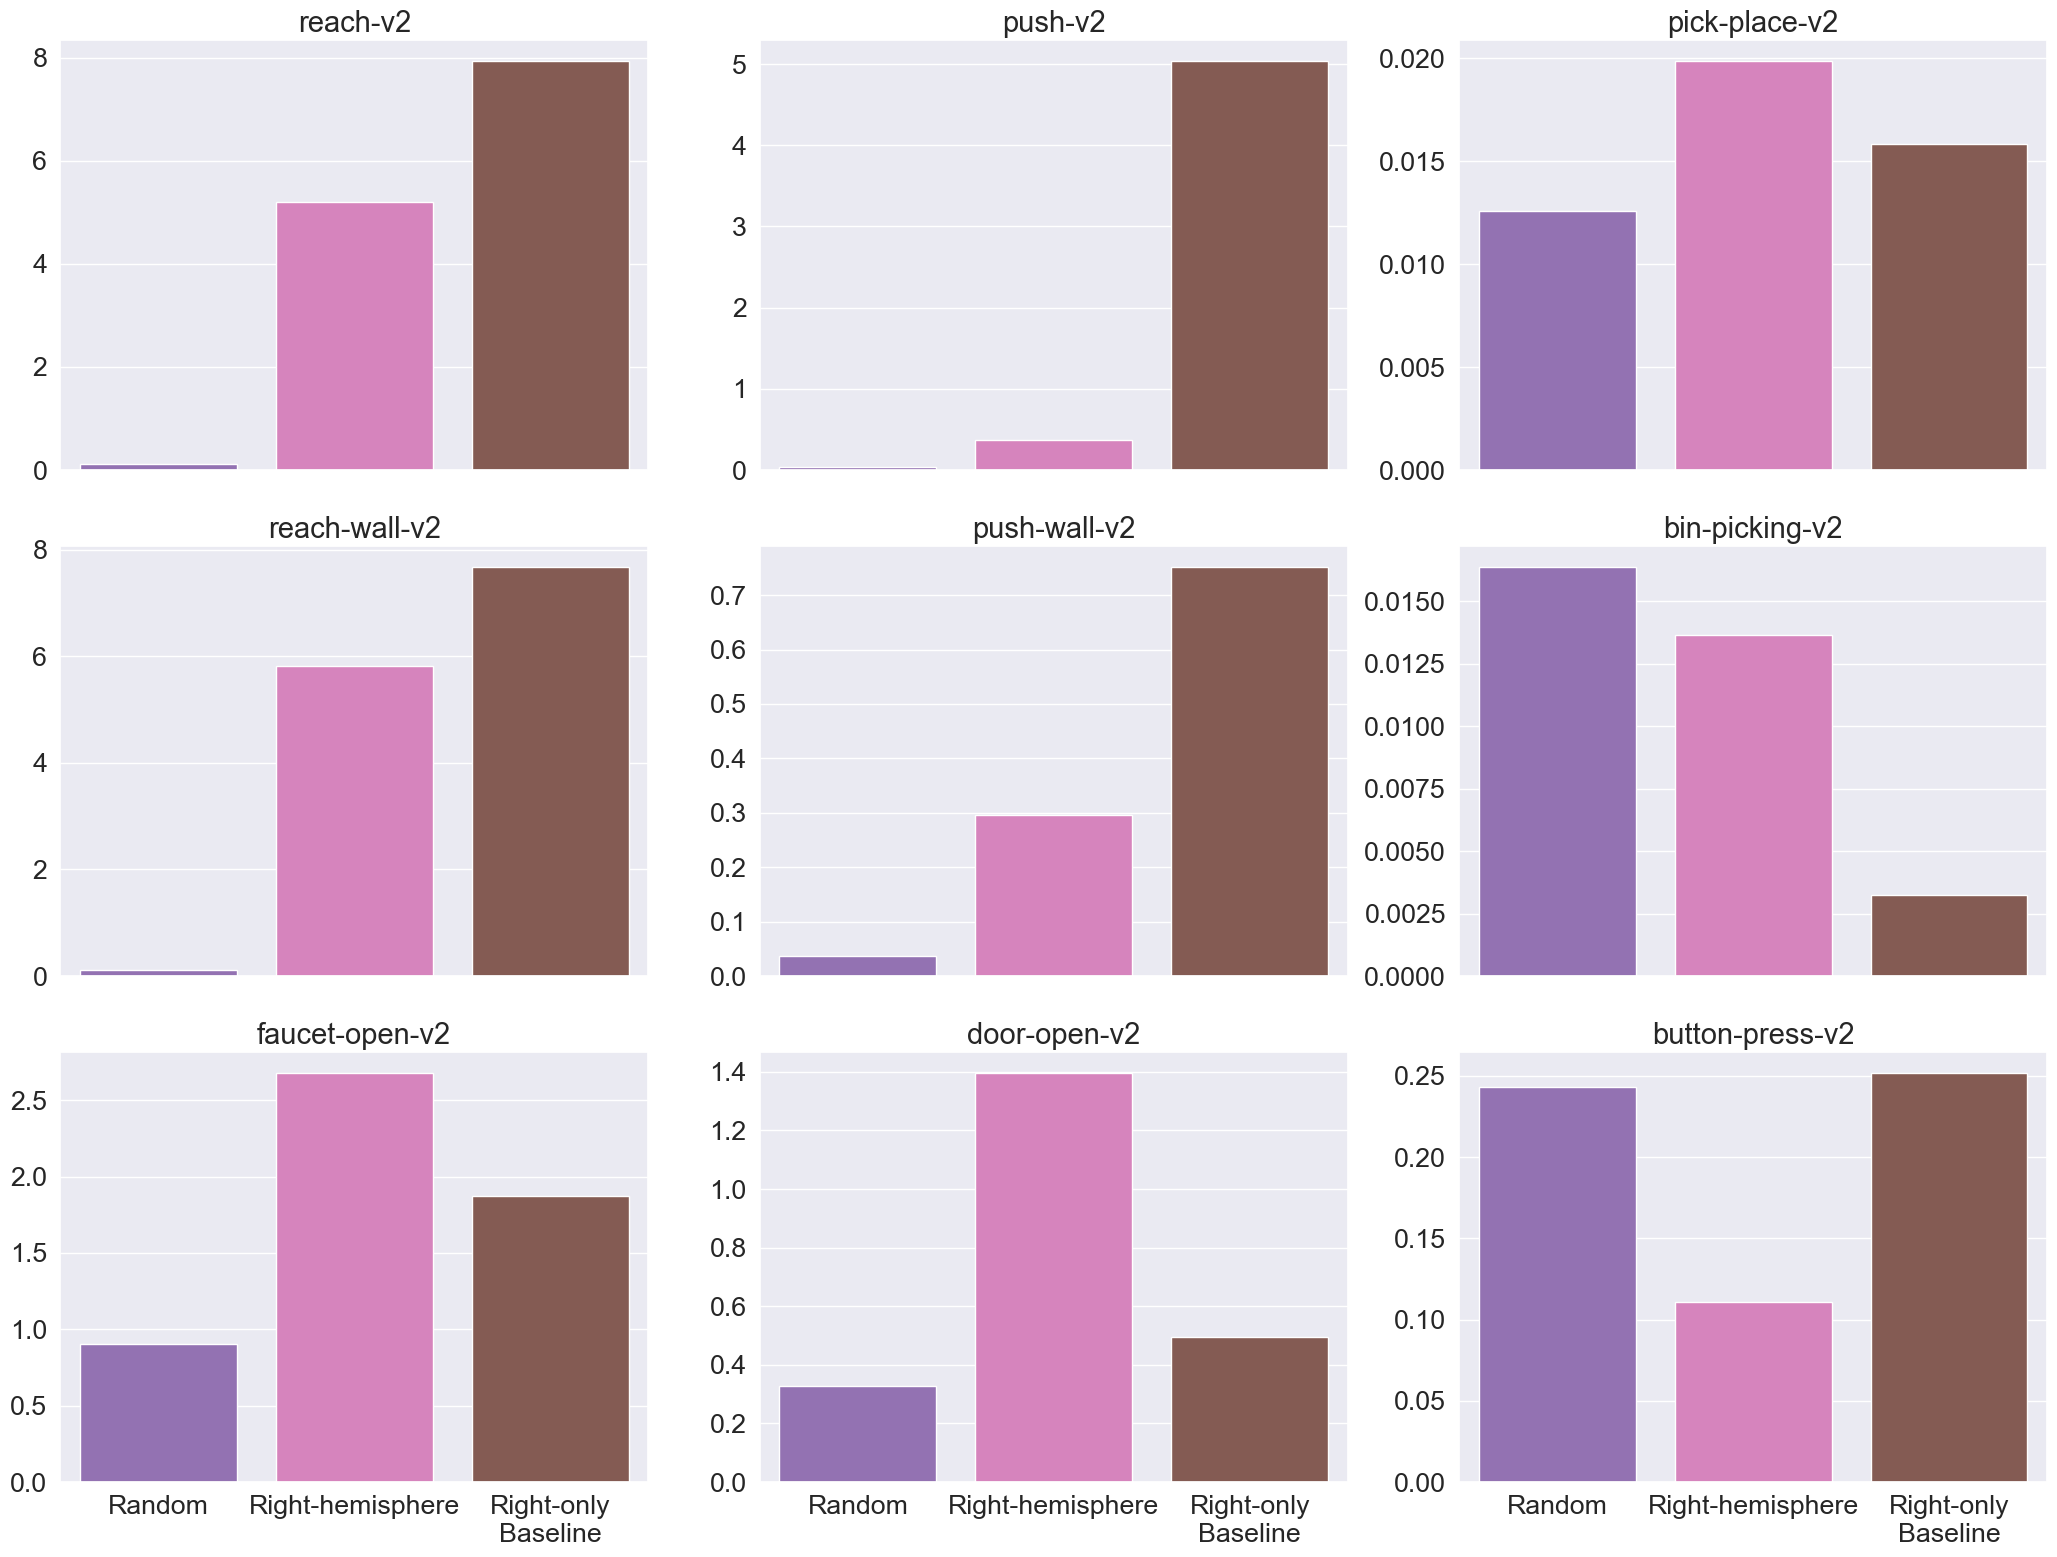

In [84]:
baselines = ['random', 'right_only', 'right_only_double_params']
to_plot = (
    train_data
    .query(f'run_name.isin({baselines})')
    # .assign(run_name = lambda x: x.run_name.apply(lambda y: '\n('.join(LABEL_MAPPING[y].split('('))))

)

fig, ax = plt.subplots(3,3, figsize=(21,16), sharex=True)
ax = ax.flatten()
for i, task in enumerate(TRAINING_TASKS):
    
    sns.barplot(
        data = (
            to_plot
            .query(f'training_task=="{task}"')
            .loc[:, ['run_name', 'reward_mean']]
            .groupby('run_name')
            .median()
            .reset_index()
        ),
        x='run_name',
        y = 'reward_mean',
        hue='run_name',
        ax = ax[i],
        palette=PALETTE
    )
    ax[i].set_title(task)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])


# plt.suptitle("RL2 test environment performance")

plt.tight_layout()
plt.show();

C:\Users\61417\AppData\Local\Temp\ipykernel_51736\1592888788.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_51736\1592888788.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_51736\1592888788.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_51736\1592888788.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() o

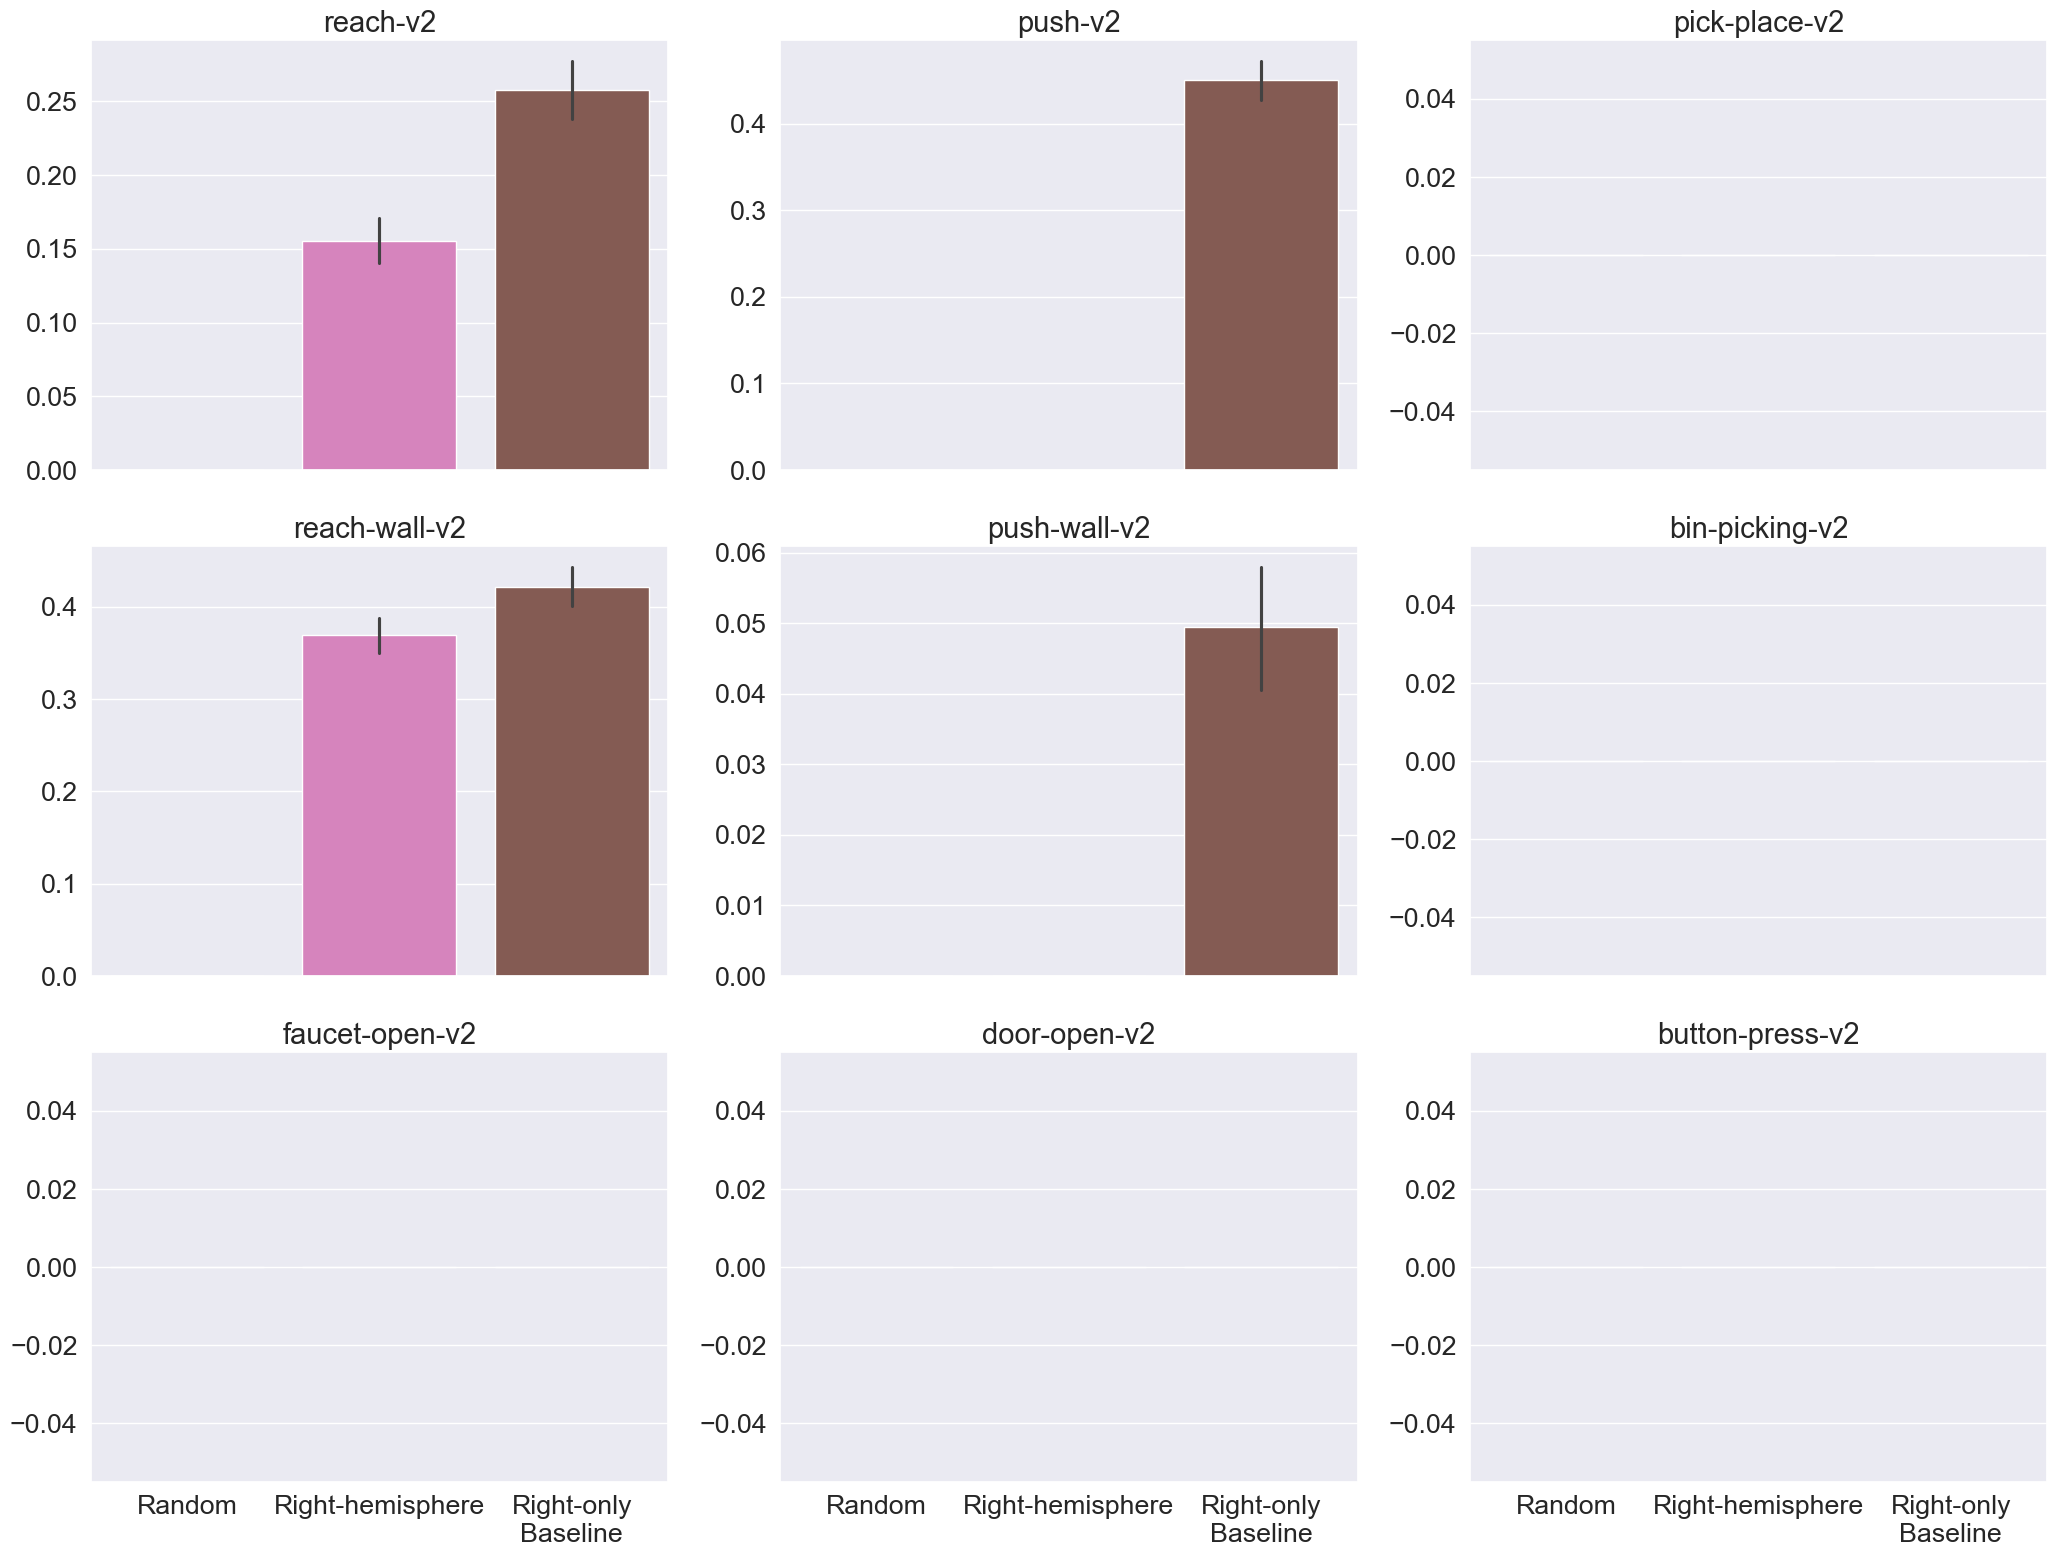

In [85]:

fig, ax = plt.subplots(3,3, figsize=(21,16), sharex=True)
ax = ax.flatten()
for i, task in enumerate(TRAINING_TASKS):
    
    sns.barplot(
        data = to_plot.query(f'training_task=="{task}"'),
        x='run_name',
        y = 'num_successes',
        hue='run_name',
        ax = ax[i],
        palette=PALETTE
    )
    ax[i].set_title(task)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])

# plt.suptitle("RL2 test environment performance")
plt.tight_layout()
plt.show();

## 2b. Train results for MetaRL

C:\Users\61417\AppData\Local\Temp\ipykernel_51736\2818638678.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_51736\2818638678.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_51736\2818638678.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])


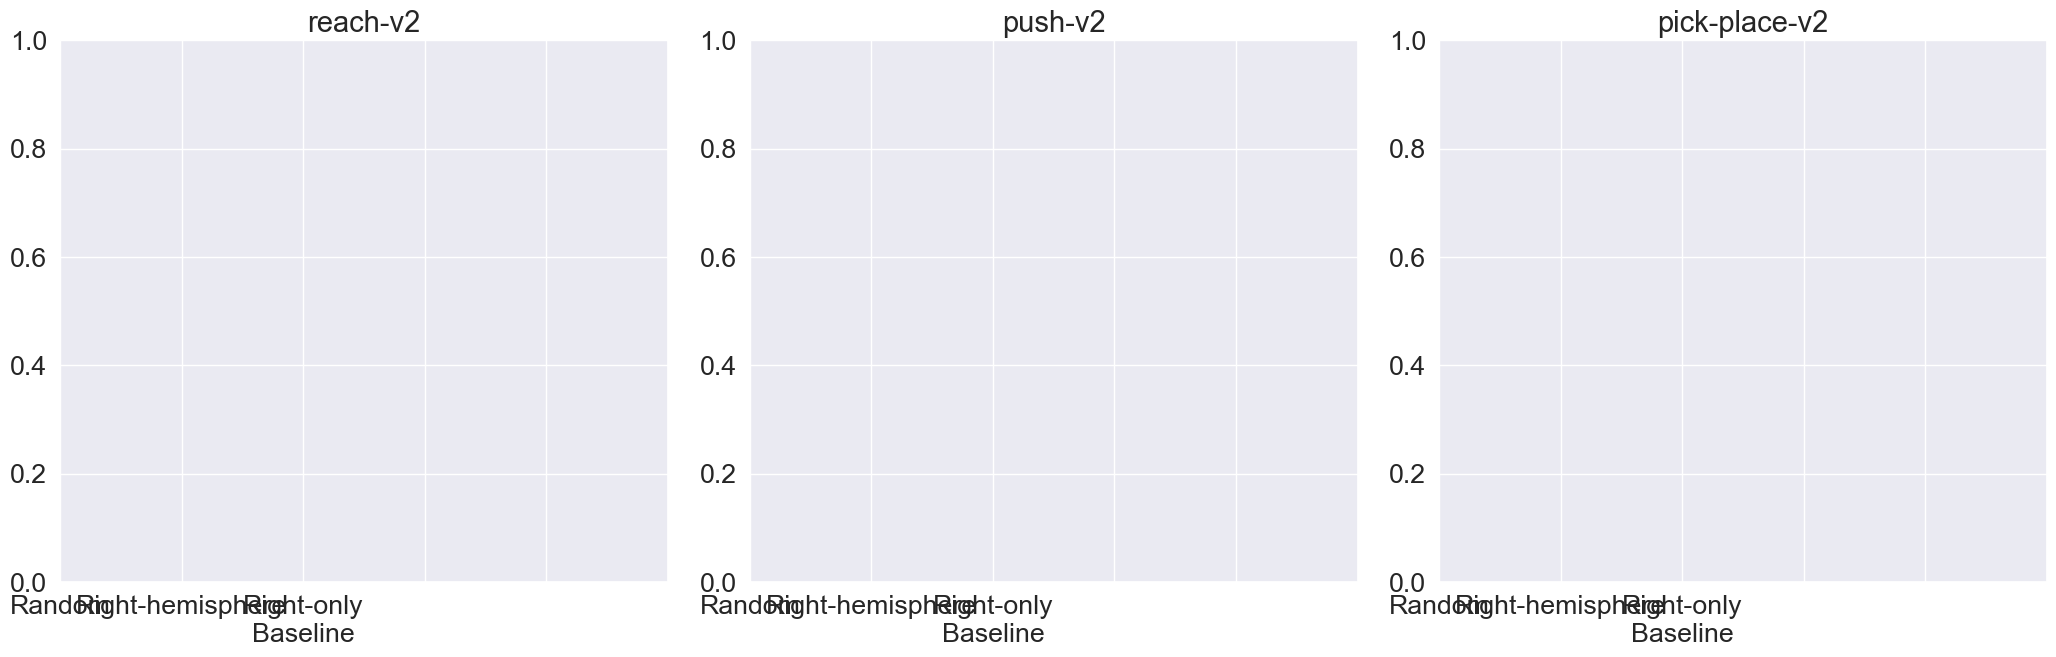

In [86]:
fig, ax = plt.subplots(1,3, figsize=(21, 7), sharex=True)
ax = ax.flatten()

metatraining_results = (
    train_data
    .query("run_name.str.contains('train')")
    .loc[:,['run_name','training_task', 'num_successes', 'reward_mean', 'frame'] + REWARD_QUANTILES]
    .assign(run_name = lambda x: x.run_name.str.replace('_train', ''))
)

for i, task in enumerate(TRAINING_TASKS[:3]):
    
    sns.barplot(
        data = (
            metatraining_results
            .query(f'training_task=="{task}"')
            .sort_values('run_name')
        ),
        x='run_name',
        y = 'reward_mean',
        hue='run_name',
        ax = ax[i],
        palette=PALETTE
    )
    ax[i].set_title(task)
    ax[i].set_title(task)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])

# plt.suptitle("RL2 train environment performance")
plt.tight_layout()
plt.show();

C:\Users\61417\AppData\Local\Temp\ipykernel_201716\2590304350.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_201716\2590304350.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])
C:\Users\61417\AppData\Local\Temp\ipykernel_201716\2590304350.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])


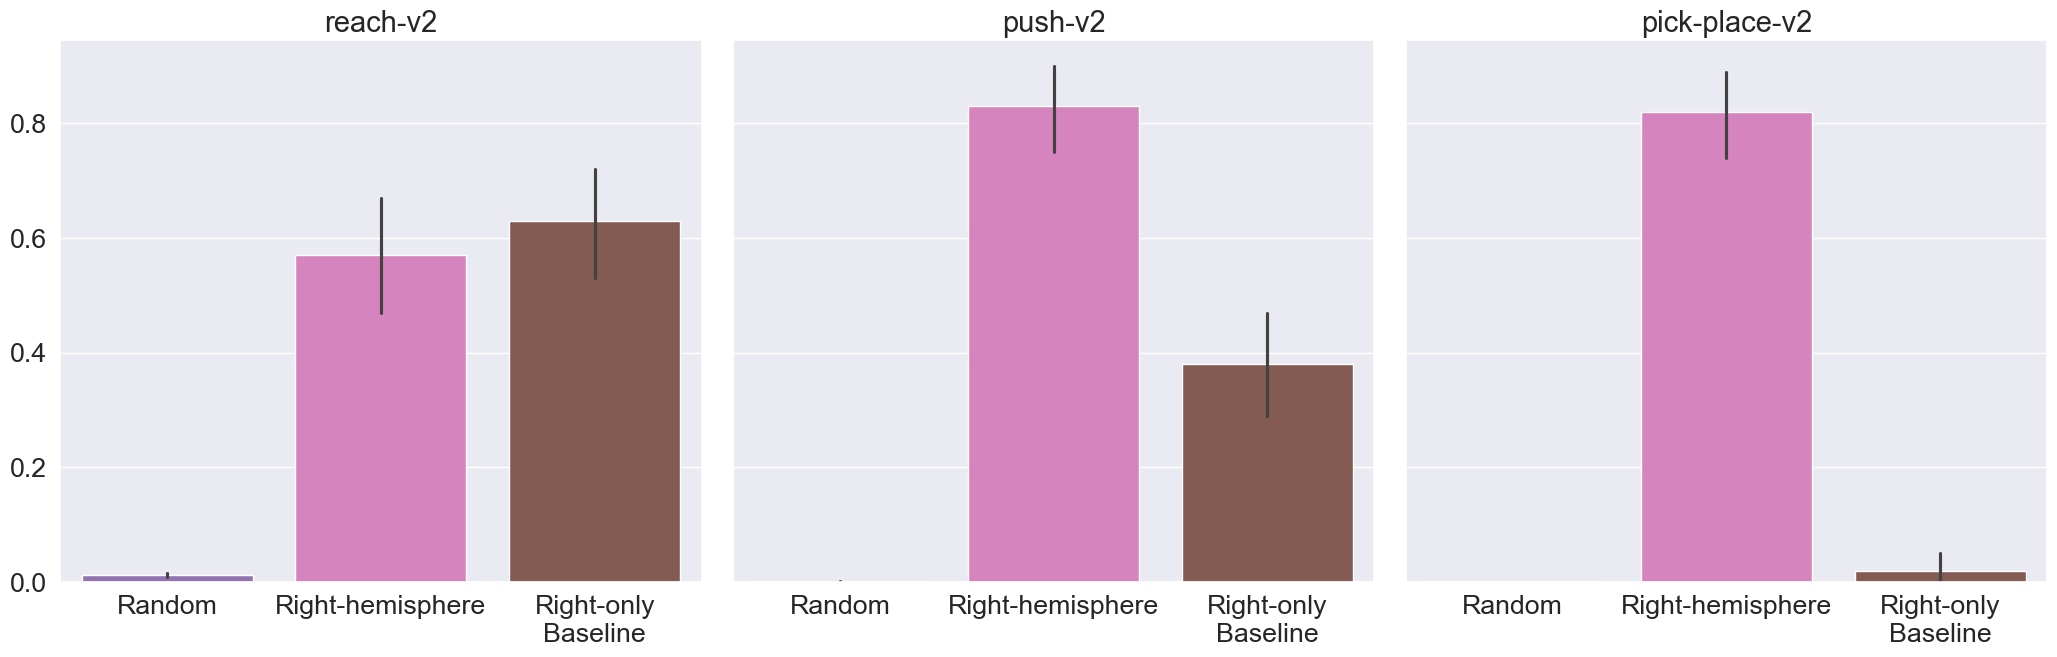

In [147]:
fig, ax = plt.subplots(1,3, figsize=(21, 7), sharex=True, sharey=True)
ax = ax.flatten()
for i, task in enumerate(TRAINING_TASKS[:3]):
    
    sns.barplot(
        data = (
            metatraining_results
            .query(f'training_task=="{task}"')
            .sort_values('run_name')
        ),
        x='run_name',
        y = 'num_successes',
        hue='run_name',
        ax = ax[i],
        palette=PALETTE
    )
    ax[i].set_title(task)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(['Random', 'Right-hemisphere', 'Right-only\nBaseline'])

plt.tight_layout()
plt.show();

Point at which left exceeds right-only-double

## 3. Cross over point / BCR

In [111]:
def get_smoothed_results(df, reward_col, span):
    return (
        df
        .loc[:, ['frame', 'training_task', 'run_name', reward_col]]
        .set_index('frame')
        .groupby(['training_task', 'run_name'])
        .apply(lambda x: x[[reward_col]].ewm(span=span).mean())
        .reset_index()
    )

def get_left_comparison(df, reward_col):
    left_only_rewards = (
        df
        .loc[:, ['training_task','run_name', 'frame', reward_col]]
        .query('run_name == "left_only_double_params"')
        .rename(columns = {reward_col: f"left_{reward_col}"})
        .drop('run_name', axis=1)
    )

    bicameral_rewards = (
        df
        .query("run_name.str.contains('bicameral')")
        .loc[:, ['training_task','run_name', 'frame', reward_col]]
    )

    return (
        left_only_rewards
        .merge(
            bicameral_rewards,
            on=['training_task', 'frame']
            )
    )

def calc_bcr(df, reward_col):
    max_steps = df.frame.max()

    distinct_task_runs = (
        df
        .loc[:, ['training_task', 'run_name']]
        .groupby(['training_task', 'run_name'])
        .count()
        .reset_index()
    )
    ## get cross_over_point
    cross_over_point_df = (
        df
        .query(f'{reward_col} < left_{reward_col}')
        .loc[:, ['run_name', 'training_task', 'frame']]
        .groupby(['run_name', 'training_task'])
        .min()
        .reset_index()
        .rename(columns={'frame': 'cross_over_point'})
        .merge(
            distinct_task_runs,
            on = ['training_task', 'run_name'],
            how='outer'
        )
        .fillna(max_steps)
    )

    bcr_df = (
        pd.merge(
            df,
            cross_over_point_df,
            on = ['run_name', 'training_task']
        )
        .assign(
            stage = lambda x: 1*(x.frame >= x.cross_over_point),
            benefit = lambda x: x[reward_col] - x[f"left_{reward_col}"],
            cost = lambda x: x[f"left_{reward_col}"] - x[reward_col]
        )
        .groupby(['training_task', 'run_name', 'stage'])
        .agg(
            {
                'benefit':'sum',
                'cost':'sum',
                'cross_over_point':'max'
            }
        )
        .reset_index()
    )

    ## split out costs and benefits by stage (i.e. before / after cross-over point)
    stage_0_benefits = (
        bcr_df
        .query('stage==0')
        .loc[:, ['training_task', 'run_name','benefit','cross_over_point']]
    )
    stage_1_costs = (
        bcr_df
        .query('stage==1')
            .loc[:, ['training_task', 'run_name','cost']]
    )

    return (
        pd.merge(
            stage_0_benefits,
            stage_1_costs,
            on = ['training_task', 'run_name'],
            how = 'outer'
        )
        .fillna(0)
        .assign(benefit_cost_ratio = lambda x: x.benefit / x.cost)
    )

# df.assign(bcr=lambda x: x['bcr'].where(x['benefit'] >= 0, 5).where(x['cost'] >= 0, 0))
def plot_bcr_heatmap(bcr_df, ax, annot_dict = {0: 'Left dominates', 5: 'Bicameral dominates'}):
    cleaned_bcr_results = (
        bcr_df
            .assign(
                benefit_cost_ratio = lambda x: x.benefit_cost_ratio.apply(lambda y: 5 if y < 0 else y)
            )
            .assign(
                annot = lambda x: x.benefit_cost_ratio.apply(
                    lambda y: annot_dict.get(y) if annot_dict.get(y) is not None else np.round(y, 3))
            )
    )
    heatmap_df = (
        cleaned_bcr_results
        .pivot_table(
            columns=['run_name'],
            values=['benefit_cost_ratio'],
            index=['training_task'])
    )

    annot_df = (
        cleaned_bcr_results
        .pivot_table(
            columns=['run_name'],
            values=['annot'],
            index=['training_task'], 
            aggfunc='max'
        )
    )

    sns.heatmap(
        data = heatmap_df,
        annot = annot_df,
        vmin=0,
        vmax=2,
        cbar=False,
        fmt="",
        ax = ax,
        annot_kws={'size':20}
    )


def get_bcr_heatmap(df,reward_col, span, ax):
    reward_col='reward_mean'

    smoothed_df = get_smoothed_results(
        df, 
        reward_col=reward_col,
        span=span
    )

    left_comparison = get_left_comparison(
        smoothed_df, 
        reward_col = reward_col
    )

    bcr_result = calc_bcr(
        left_comparison,
        reward_col=reward_col
    )

    plot_bcr_heatmap(bcr_result, ax)

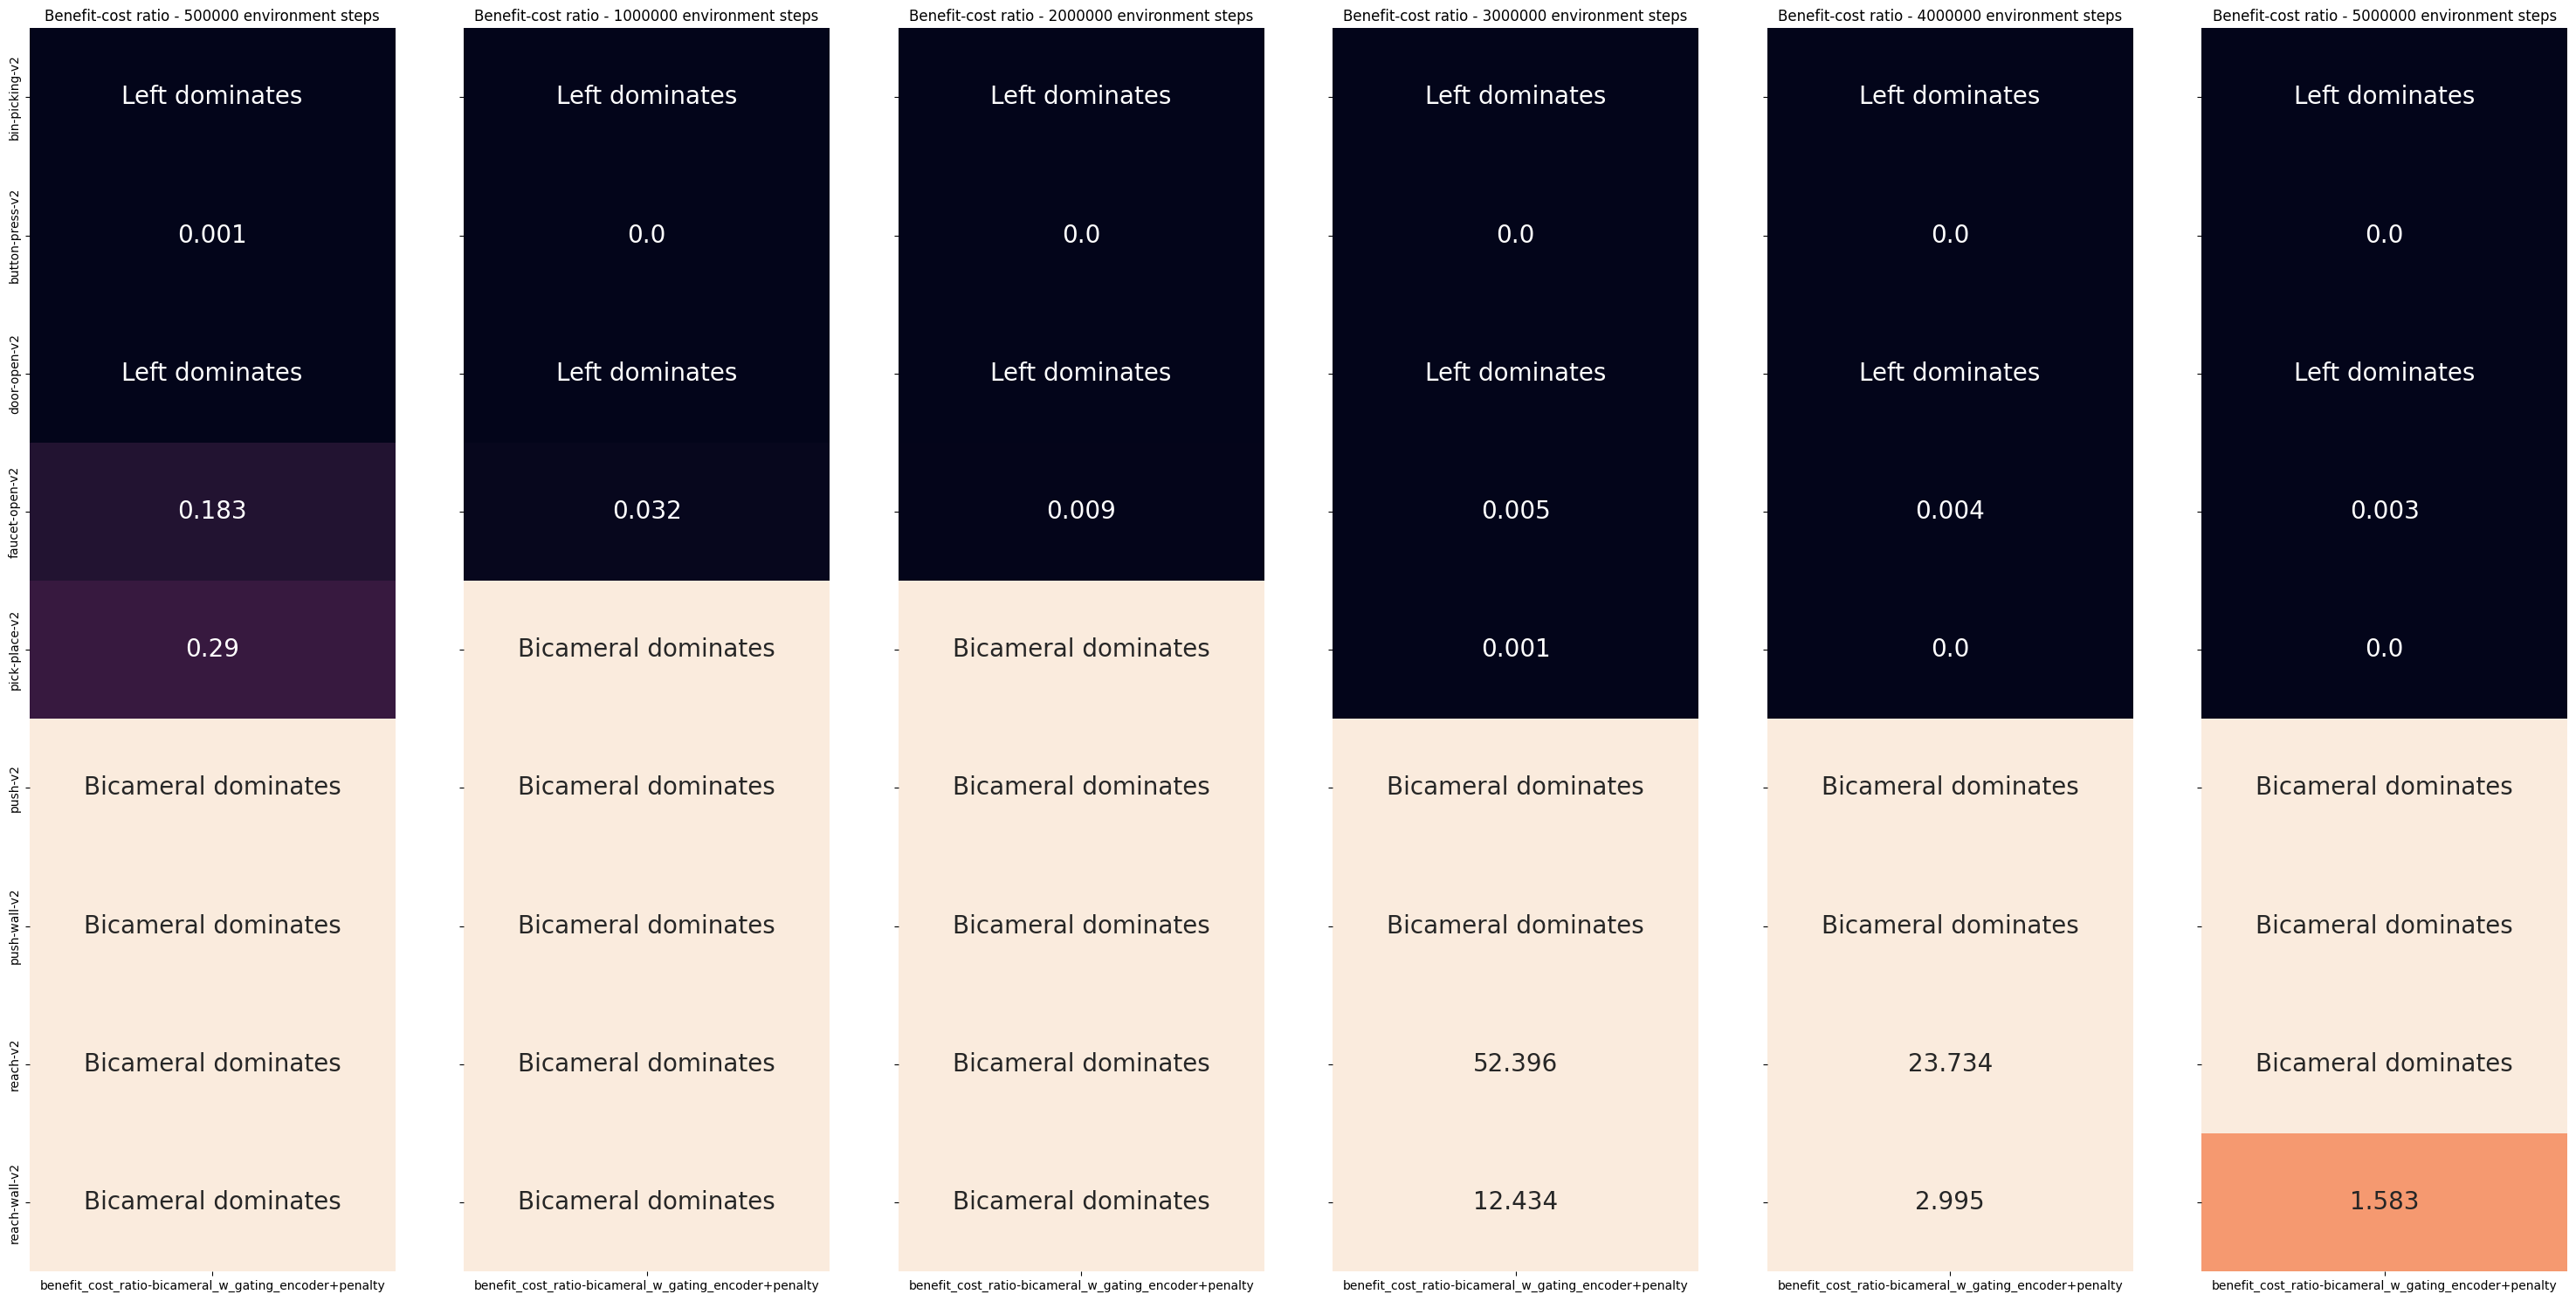

In [112]:
to_remove = ['random', 'right_only']
to_do =['bicameral_w_gating_encoder+penalty','left_only_double_params']
reward_col = 'reward_mean'
frame_lims = [5e5, 1e6, 2e6, 3e6, 4e6, 5e6]
span=10

fig, ax = plt.subplots(1,6,figsize= (30, 15), sharex = True, sharey=True)
ax = ax.flatten()

for i, frame_lim in enumerate(frame_lims):

    df = (
        train_data
        .query(f'run_name.isin({to_do})')
        .query(f'frame <= {frame_lim}')
    )

    get_bcr_heatmap(df, reward_col, span, ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(f'Benefit-cost ratio - {int(frame_lim)} environment steps')


plt.tight_layout()
plt.show();

In [21]:
max_steps = 1e6
reward_col = 'reward_mean'
df = (
    train_data
    .query(f'~run_name.isin({to_remove})')
    .query(f'frame <= 1e6')
)
df = get_smoothed_results(df, reward_col, 10)
df = get_left_comparison(df, reward_col)

cross_over_point = (
    df
    .query(f'{reward_col} < left_{reward_col}')
    .loc[:, ['run_name', 'training_task', 'frame']]
    .groupby(['run_name', 'training_task'])
    .min()
    .reset_index()
    .rename(columns={'frame': 'cross_over_point'})
    .merge(
        distinct_task_runs,
        on = ['training_task', 'run_name'],
        how='outer'
    )
    .fillna(max_steps)
)
# k = calc_bcr(df, reward_col)
# k

NameError: name 'distinct_task_runs' is not defined

In [ ]:
cross_over_point_df

training_task    frame  left_reward_mean  \
0     button-press-v2    10000          0.159898   
1     button-press-v2    10000          0.159898   
2     button-press-v2    10000          0.159898   
3     button-press-v2    20000          0.169554   
4     button-press-v2    20000          0.169554   
...               ...      ...               ...   
1795         reach-v2   990000          6.527842   
1796         reach-v2   990000          6.527842   
1797         reach-v2  1000000          6.623548   
1798         reach-v2  1000000          6.623548   
1799         reach-v2  1000000          6.623548   

                                run_name  reward_mean  
0             bicameral_w_gating_encoder     0.145649  
1     bicameral_w_gating_encoder+penalty     0.140902  
2            bicameral_w_gating_schedule     0.122894  
3             bicameral_w_gating_encoder     0.146888  
4     bicameral_w_gating_encoder+penalty     0.146144  
...                                  ...          ...  
1795  bicameral_w_gating_encoder+penalty     7.209668  
1796         bicameral_w_gating_schedule     8.456949  
1797          bicameral_w_gating_encoder     8.017995  
1798  bicameral_w_gating_encoder+penalty     7.319661  
1799         bicameral_w_gating_schedule     8.387177  

[1800 rows x 5 columns]

In [ ]:
reward_col = 'reward_mean'
df = (
    train_data
    .query(f'~run_name.isin({to_remove})')
    .query(f'frame <= 5e6')
)
df = get_smoothed_results(df, reward_col, 10)
df = get_left_comparison(df, reward_col)


cross_over_point_df = (
    df
    .assign(stage = lambda x: x[f'left_{reward_col}'] > x[reward_col])
    .loc[:, ['run_name', 'training_task', 'frame', 'stage']]
    # .groupby(['run_name', 'training_task', 'stage'])
    # .min()
    # .reset_index()
    # .rename(columns={'frame': 'cross_over_point'})
    # .pivot(
    #     index =['run_name', 'training_task'],
    #     values = 'cross_over_point',
    #     columns='stage'
    # )
#     .reset_index()
#     .rename(columns={True: 'pre_cross_over', False: 'post_cross_over'})
#     .fillna({'post_cross_over': 0, 'pre_cross_over': 5e6})
#     .assign(cross_over_point = lambda x: (x.post_cross_over / 10000) * x.pre_cross_over)
#     .drop(['post_cross_over', 'pre_cross_over'], axis=1)
)

# bcr_df = (
#     pd.merge(
#         df,
#         cross_over_point_df,
#         on = ['run_name', 'training_task']
#     )
#     .assign(
#         stage = lambda x: 1*(x.frame >= x.cross_over_point),
#         benefit = lambda x: x[reward_col] - x[f"left_{reward_col}"],
#         cost = lambda x: x[f"left_{reward_col}"] - x[reward_col]
#     )
#     .groupby(['training_task', 'run_name', 'stage'])
#     .agg(
#         {
#             'benefit':'sum',
#             'cost':'sum',
#             'cross_over_point':'max'
#         }
#     )
#     .reset_index()
# )

In [ ]:
# Find the first iteration where reward2 is greater than reward1
def get_cross_over_point(df):
    first_iteration_reward2_gt_reward1 = df.loc[df['left_reward_mean'] > df['reward_mean'], 'frame'].min()

    # If reward1 is always greater than reward2, return the maximum iter
    if (df['reward_mean'] > df['left_reward_mean']).all():
        result = df['frame'].max()
    # If reward2 is always greater than reward1, return the minimum iter
    elif (df['left_reward_mean'] > df['reward_mean']).all():
        result = 0#df['frame'].min()
    # Otherwise, return the first iteration where reward2 is greater than reward1
    else:
        result = first_iteration_reward2_gt_reward1

    return result

df.groupby(['training_task','run_name']).apply(get_cross_over_point).reset_index()

KeyError: 'left_reward_mean'

In [ ]:
reward_col='reward_mean'

smoothed_df2 = get_smoothed_results(
    (
        train_data
        .query(f"~run_name.isin({to_remove})")
    ), 
    reward_col=reward_col,
    span=10
)

left_comparison2 = get_left_comparison(
    smoothed_df2, 
    reward_col = reward_col
)

left_comparison2

training_task    frame  left_reward_mean  \
0     button-press-v2    10000          0.159898   
1     button-press-v2    10000          0.159898   
2     button-press-v2    10000          0.159898   
3     button-press-v2    20000          0.169554   
4     button-press-v2    20000          0.169554   
...               ...      ...               ...   
8995         reach-v2  4990000          8.611332   
8996         reach-v2  4990000          8.611332   
8997         reach-v2  5000000          8.629772   
8998         reach-v2  5000000          8.629772   
8999         reach-v2  5000000          8.629772   

                                run_name  reward_mean  
0             bicameral_w_gating_encoder     0.145649  
1     bicameral_w_gating_encoder+penalty     0.140902  
2            bicameral_w_gating_schedule     0.122894  
3             bicameral_w_gating_encoder     0.146888  
4     bicameral_w_gating_encoder+penalty     0.146144  
...                                  ...          ...  
8995  bicameral_w_gating_encoder+penalty     8.176569  
8996         bicameral_w_gating_schedule     7.177553  
8997          bicameral_w_gating_encoder     8.694279  
8998  bicameral_w_gating_encoder+penalty     8.154990  
8999         bicameral_w_gating_schedule     7.131496  

[9000 rows x 5 columns]

In [ ]:
distinct_task_runs = (
    left_comparison2
    .loc[:, ['training_task', 'run_name']]
    .groupby(['training_task', 'run_name'])
    .count()
    .reset_index()
)


(
    left_comparison2
    .query('frame<1e6')
    .query(f'{reward_col} < left_{reward_col}')
    .loc[:, ['run_name', 'training_task', 'frame']]
    .groupby(['run_name', 'training_task'])
    .min()
    .reset_index()
    .rename(columns={'frame': 'cross_over_point'})
    .merge(
        distinct_task_runs,
        on = ['training_task', 'run_name'],
        how='outer'
    )
    .fillna(1e6)
)

NameError: name 'left_comparison2' is not defined

In [ ]:
reward_col='reward_mean'

smoothed_df2 = get_smoothed_results(
    (
        train_data
        .query(f"~run_name.isin({to_remove})")
    ), 
    reward_col=reward_col,
    span=10
)

left_comparison2 = get_left_comparison(
    smoothed_df2, 
    reward_col = reward_col
)

bcr_result2 = calc_bcr(
    left_comparison2,
    reward_col=reward_col
)

plot_bcr_heatmap(bcr_result2)

NameError: name 'get_smoothed_results' is not defined

In [ ]:
reward_col = 'reward_mean'

smoothed_df = (
    train_data
    .query(f"~run_name.isin({to_remove})")
    .loc[:, ['frame', 'training_task', 'run_name', reward_col]]
    .set_index('frame')
    .groupby(['training_task', 'run_name'])
    .apply(lambda x: x[[reward_col]].ewm(span=25).mean())
    .reset_index()
)

left_only_rewards = (
    smoothed_df
    .loc[:, ['training_task','run_name', 'frame', reward_col]]
    .query('run_name == "left_only_double_params"')
    .rename(columns = {reward_col: f"left_{reward_col}"})
    .drop('run_name', axis=1)
)

bicameral_rewards = (
    smoothed_df
    .query("run_name.str.contains('bicameral')")
    .loc[:, ['training_task','run_name', 'frame', reward_col]]
)

joined_rewards = (
    left_only_rewards
    .merge(
        bicameral_rewards,
        on=['training_task', 'frame']
        )
)

cross_over_point_df = (
    joined_rewards
    .query(f'left_{reward_col} > {reward_col}')
    .loc[:, ['run_name', 'training_task', 'frame']]
    .groupby(['run_name', 'training_task'])
    .min()
    .reset_index()
    .rename(columns={'frame': 'cross_over_point'})
)

In [ ]:
bcr_df = (
    joined_rewards
    .merge(
        cross_over_point_df,
        on = ['run_name', 'training_task']
    )
    .assign(
        stage = lambda x: 1*(x.frame >= x.cross_over_point),
        benefit = lambda x: x.reward_mean - x.left_reward_mean,
        cost = lambda x: x.left_reward_mean - x.reward_mean
    )
    .groupby(['training_task', 'run_name', 'stage'])
    .agg(
        {
            'benefit':'sum',
            'cost':'sum',
            'cross_over_point':'max'
        }
    )
    .reset_index()
)




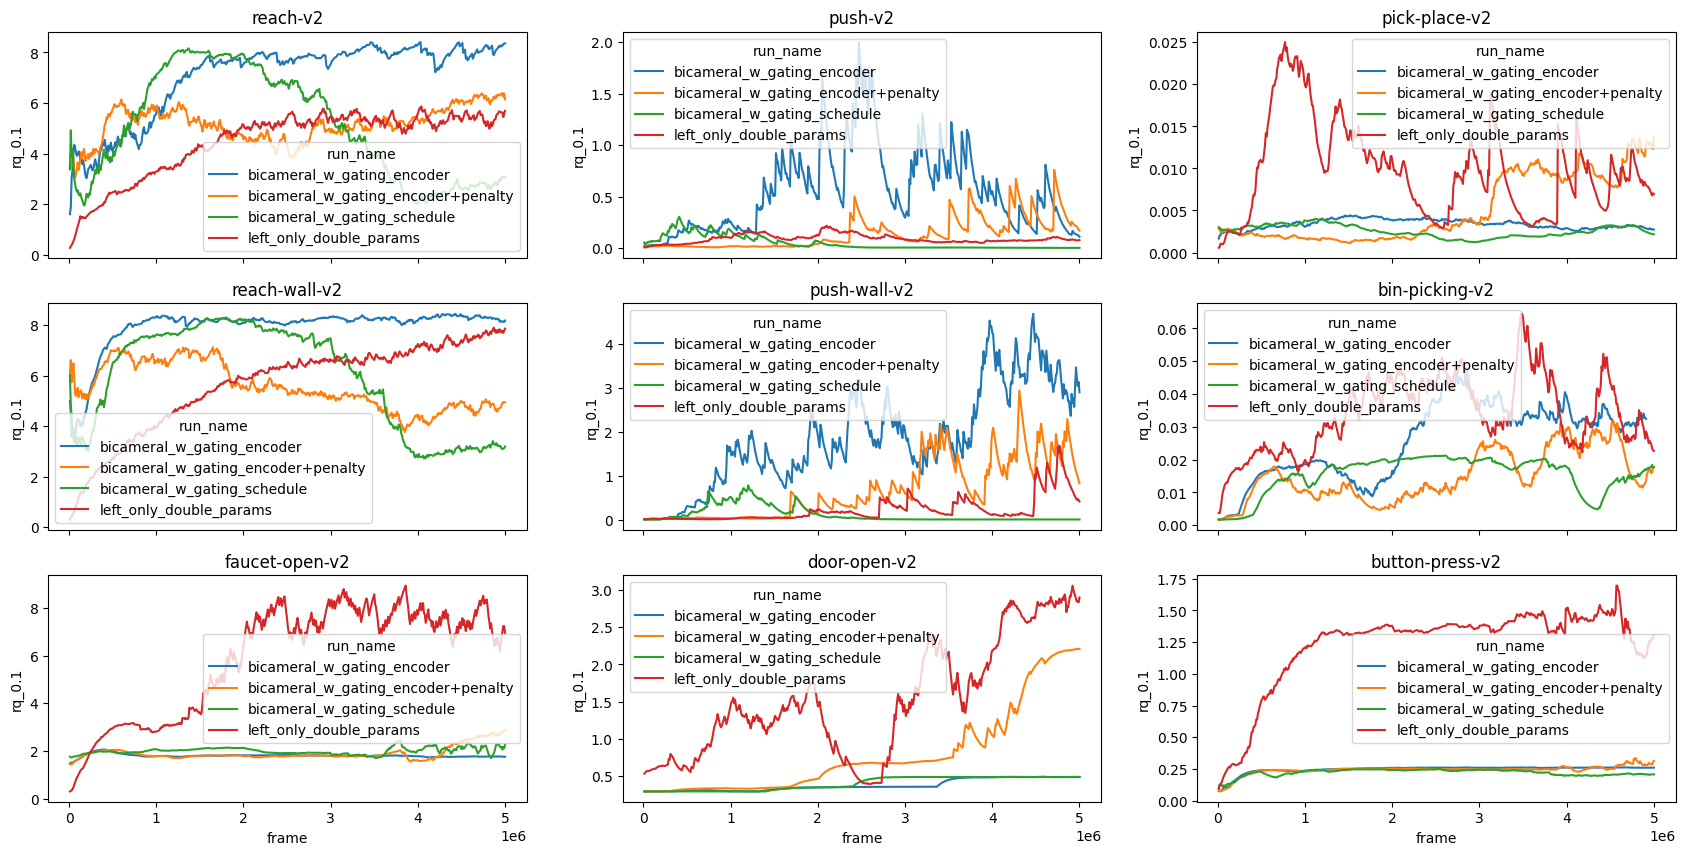

In [117]:
fig, ax = plt.subplots(3,3, figsize = (21, 10), sharex=True)
ax = ax.flatten()
to_remove = ['random', 'right_only', 'right_only_double_params', 'right_only_double_params_train', 'right_only_train']
reward_col = 'rq_0.1'

smoothed_df = (
    train_data
    .query(f"~run_name.isin({to_remove})")
    .loc[:, ['frame', 'training_task', 'run_name', reward_col]]
    .set_index('frame')
    .groupby(['training_task', 'run_name'])
    .apply(lambda x: x[[reward_col]].ewm(span=25).mean())
    .reset_index()
)

for i, task in enumerate(training_tasks):
    sns.lineplot(
        data = smoothed_df.query(f"training_task=='{task}'"),
        x = 'frame',
        y = reward_col,
        hue='run_name',
        ax = ax[i],
        palette=PALETTE
    )
    # ax[i].axvline(bcr_df.query(f"training_task=='{task}'").loc[:,'cross_over_point'].values)
    ax[i].set_title(task)

In [ ]:
stage_0_benefits = (
    bcr_df
    .query('stage==0')
    .loc[:, ['training_task', 'run_name','benefit','cross_over_point']]
)
stage_1_costs = (
    bcr_df
    .query('stage==1')
        .loc[:, ['training_task', 'run_name','cost']]
)

bcr_results = (
    pd.merge(
        stage_0_benefits,
        stage_1_costs,
        on = ['training_task', 'run_name'],
        how = 'outer'
    )
    .fillna(0)
    .assign(benefit_cost_ratio = lambda x: x.benefit / x.cost)
)

<Axes: xlabel='None-run_name', ylabel='training_task'>

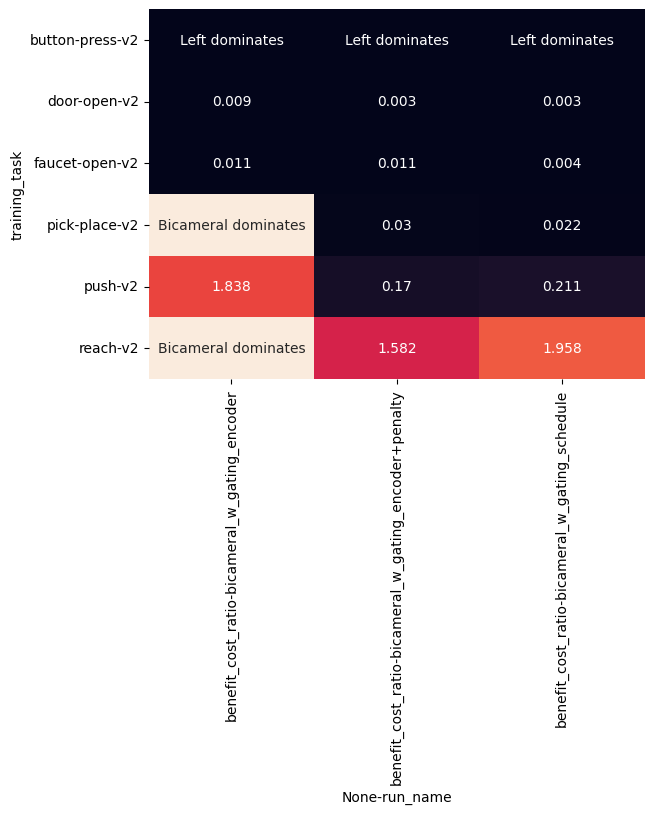

In [ ]:
annot_dict = {0: 'Left dominates', 5: 'Bicameral dominates'}
cleaned_bcr_results = (
        bcr_results
            .assign(benefit_cost_ratio = lambda x: x.benefit_cost_ratio.apply(lambda y: 5 if y < 0 else y))
            .assign(
                annot = lambda x: x.benefit_cost_ratio.apply(
                    lambda y: annot_dict.get(y) if annot_dict.get(y) is not None else np.round(y, 3))
            )
)
heatmap_df = (
    cleaned_bcr_results
    .pivot_table(
        columns=['run_name'],
        values=['benefit_cost_ratio'],
        index=['training_task'])
)

annot_df = (
    cleaned_bcr_results
    .pivot_table(
        columns=['run_name'],
        values=['annot'],
        index=['training_task'], aggfunc='max')
)


sns.heatmap(
    data = heatmap_df,
    annot = annot_df,
    vmin=0,
    vmax=3,
    cbar=False,
    fmt=""
)

In [ ]:
combined_test_left_df = (
    pd.merge(
        (
            left_eval_data
            .loc[:,['frame','training_task','run_name', 'reward_mean']]
        ), 
        (
            test_data
            .query(f"run_name=='left_only_double_params'")
            .loc[:,['frame','training_task', 'reward_mean']]
            .rename(columns = {'reward_mean':'left_reward_mean'})
        ),
        on=['frame', 'training_task']
    )
    .assign(
        stage=lambda x: 1*(x.frame >= 4e6),
        reward_diff = lambda x: x.reward_mean - x.left_reward_mean
    )
    .drop(['frame', 'left_reward_mean', 'reward_mean'], axis=1)
    .groupby(['training_task', 'run_name', 'stage'])
    .sum()
    .reset_index()
    
)




<Axes: xlabel='benefit', ylabel='reward_diff'>

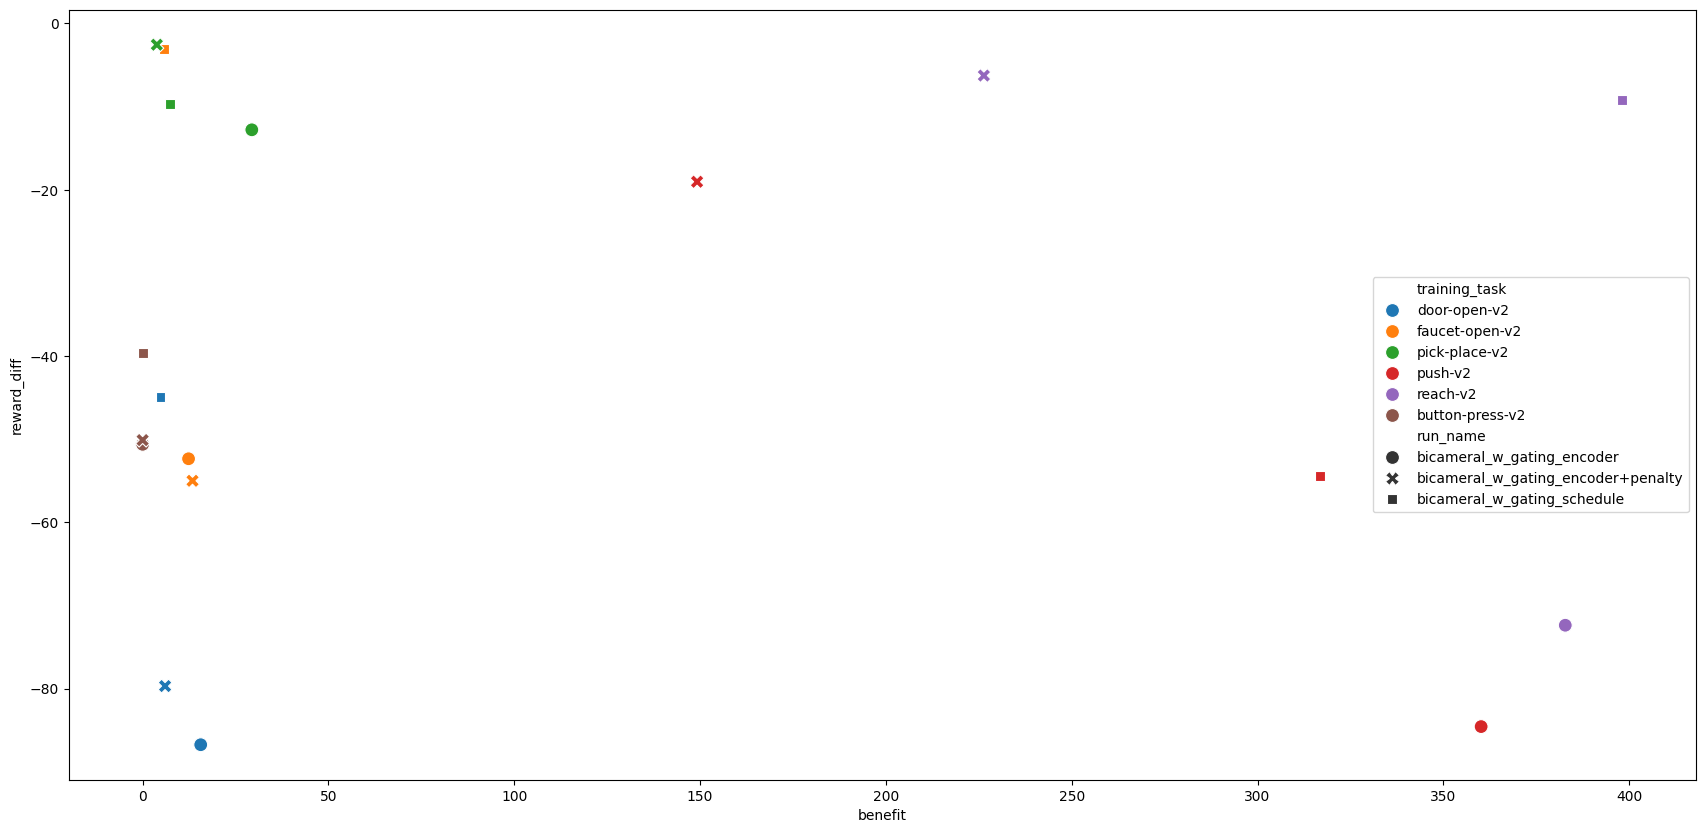

In [ ]:
bcr_to_left_comp = (
    bcr_results
    .merge(
        combined_test_left_df.query('stage==1'), 
        on = ['training_task', 'run_name'])
)

fig, ax = plt.subplots(figsize=(21, 10))

sns.scatterplot(
    data = bcr_to_left_comp,
    x = 'benefit',
    y= 'reward_diff',
    hue = 'training_task',
    style='run_name',
    s=100
)

In [ ]:
to_remove = ["random","right_only"]

time_to_vals = ['q_25', 'q_50', 'q_75', 'q_90']

df = (
    train_data
    # .query(f'~run_name.isin({to_remove})')
    .loc[:,['training_task','run_name', 'frame', 'reward_mean']]
)

quantiles=(
    df
    .loc[:,['training_task','run_name', 'reward_mean']]
    .groupby(['training_task','run_name'])
    .quantile([0.25, 0.5, 0.75, 0.9])
    .reset_index()
    .rename(columns={'level_2':'quantile'})
    .pivot_table(
        values=['reward_mean'],
        columns='quantile',
        index=['training_task', 'run_name']
    )
    .reset_index()
)
quantiles.columns = ['training_task','run_name'] + time_to_vals
time_to_data = (
    quantiles
    .merge(df, on=['run_name', 'training_task'])
    .assign(
        time_to_q_25=lambda x: x.frame * (x.reward_mean>=x.q_25),
        time_to_q_50=lambda x: x.frame * (x.reward_mean>=x.q_50),
        time_to_q_75=lambda x: x.frame * (x.reward_mean>=x.q_75),
        time_to_q_90=lambda x: x.frame * (x.reward_mean>=x.q_90)
    )
)

left_baseline_q = (
    quantiles
    .query('run_name=="left_only_double_params"')
    .loc[:,['training_task', 'run_name', *time_to_vals]]
)
q_to_left = pd.DataFrame()
for val in time_to_vals:
    tmp_left = (
        quantiles
        .loc[:,['training_task', 'run_name', val]]
        .merge(
            (
                left_baseline_q
                .loc[:, ['training_task', val]]
                .rename(columns={val:'baseline'})
            ), 
            on=['training_task']
        )
        .assign(**{f'{val}_ratio': lambda x: x[val] / x.baseline})
        .drop('baseline', axis=1)
        .set_index(['training_task', 'run_name'])

    )

    q_to_left = pd.concat([q_to_left, tmp_left], axis=1)

time_to_vals_dfs = pd.DataFrame()
for val in time_to_vals:
    tmp = (
        time_to_data
        .query(f'time_to_{val}> 0')
        .groupby(['training_task','run_name'])
        .agg({f'time_to_{val}':'min'})
        .reset_index()
    )
    baseline_vals = (
        tmp
        .query('run_name=="left_only_double_params"')
        .rename(columns={f'time_to_{val}':'baseline'})
        .drop('run_name', axis=1)
    )
    tmp = (
        tmp
        .merge(
            baseline_vals,
            on='training_task'
        )
        .assign(**{f'time_to_{val}_ratio': lambda x: x[f'time_to_{val}'] / x.baseline})
        .set_index(['training_task', 'run_name'])
    )

    time_to_vals_dfs = pd.concat([time_to_vals_dfs, tmp], axis = 1)


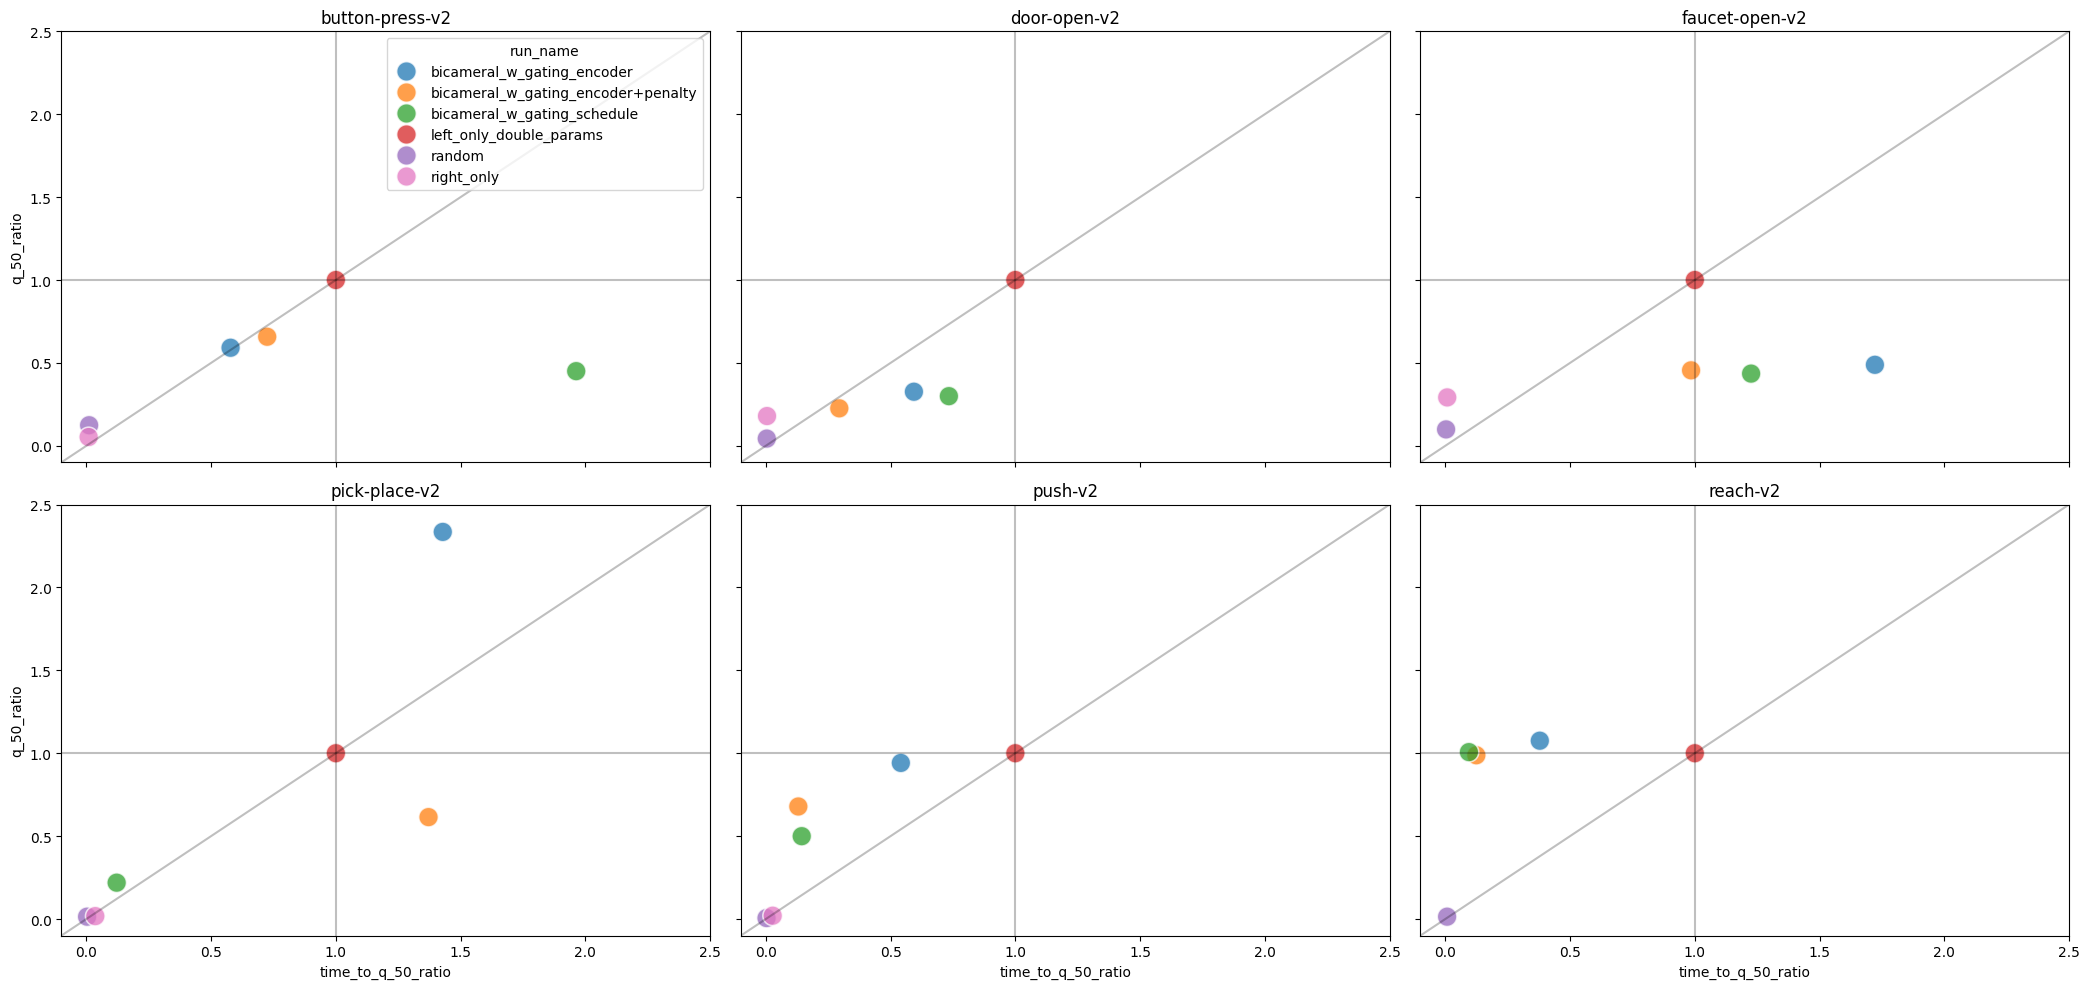

In [ ]:
quantiles_and_times = pd.concat([time_to_vals_dfs, q_to_left], axis=1).reset_index()
fig, ax = plt.subplots(2, 3, figsize = (21, 10), sharex=True, sharey=True)
ax = ax.flatten()
to_plot = 'q_50'

for i, task in enumerate(training_tasks):
    sns.scatterplot(
        data = (
            quantiles_and_times
            .query(f"training_task=='{task}'")
        ),
        x=f'time_to_{to_plot}_ratio',
        y=f'{to_plot}_ratio',
        hue='run_name',
        ax=ax[i],
        palette=PALETTE,
        s = 200,
        alpha = 0.75
    )
    ax[i].set_title(f"{task}")
    ax[i].axhline(1, c='black', alpha=0.25)
    ax[i].axvline(1, c='black', alpha=0.25)
    ax[i].set_xlim(-.1, 2.5)
    ax[i].set_ylim(-.1, 2.5)

    ax[i].plot([-5., 5.], [-5.,5.], c='black', alpha=0.25)
    if i > 0:
        ax[i].get_legend().remove()


plt.tight_layout()
plt.show();


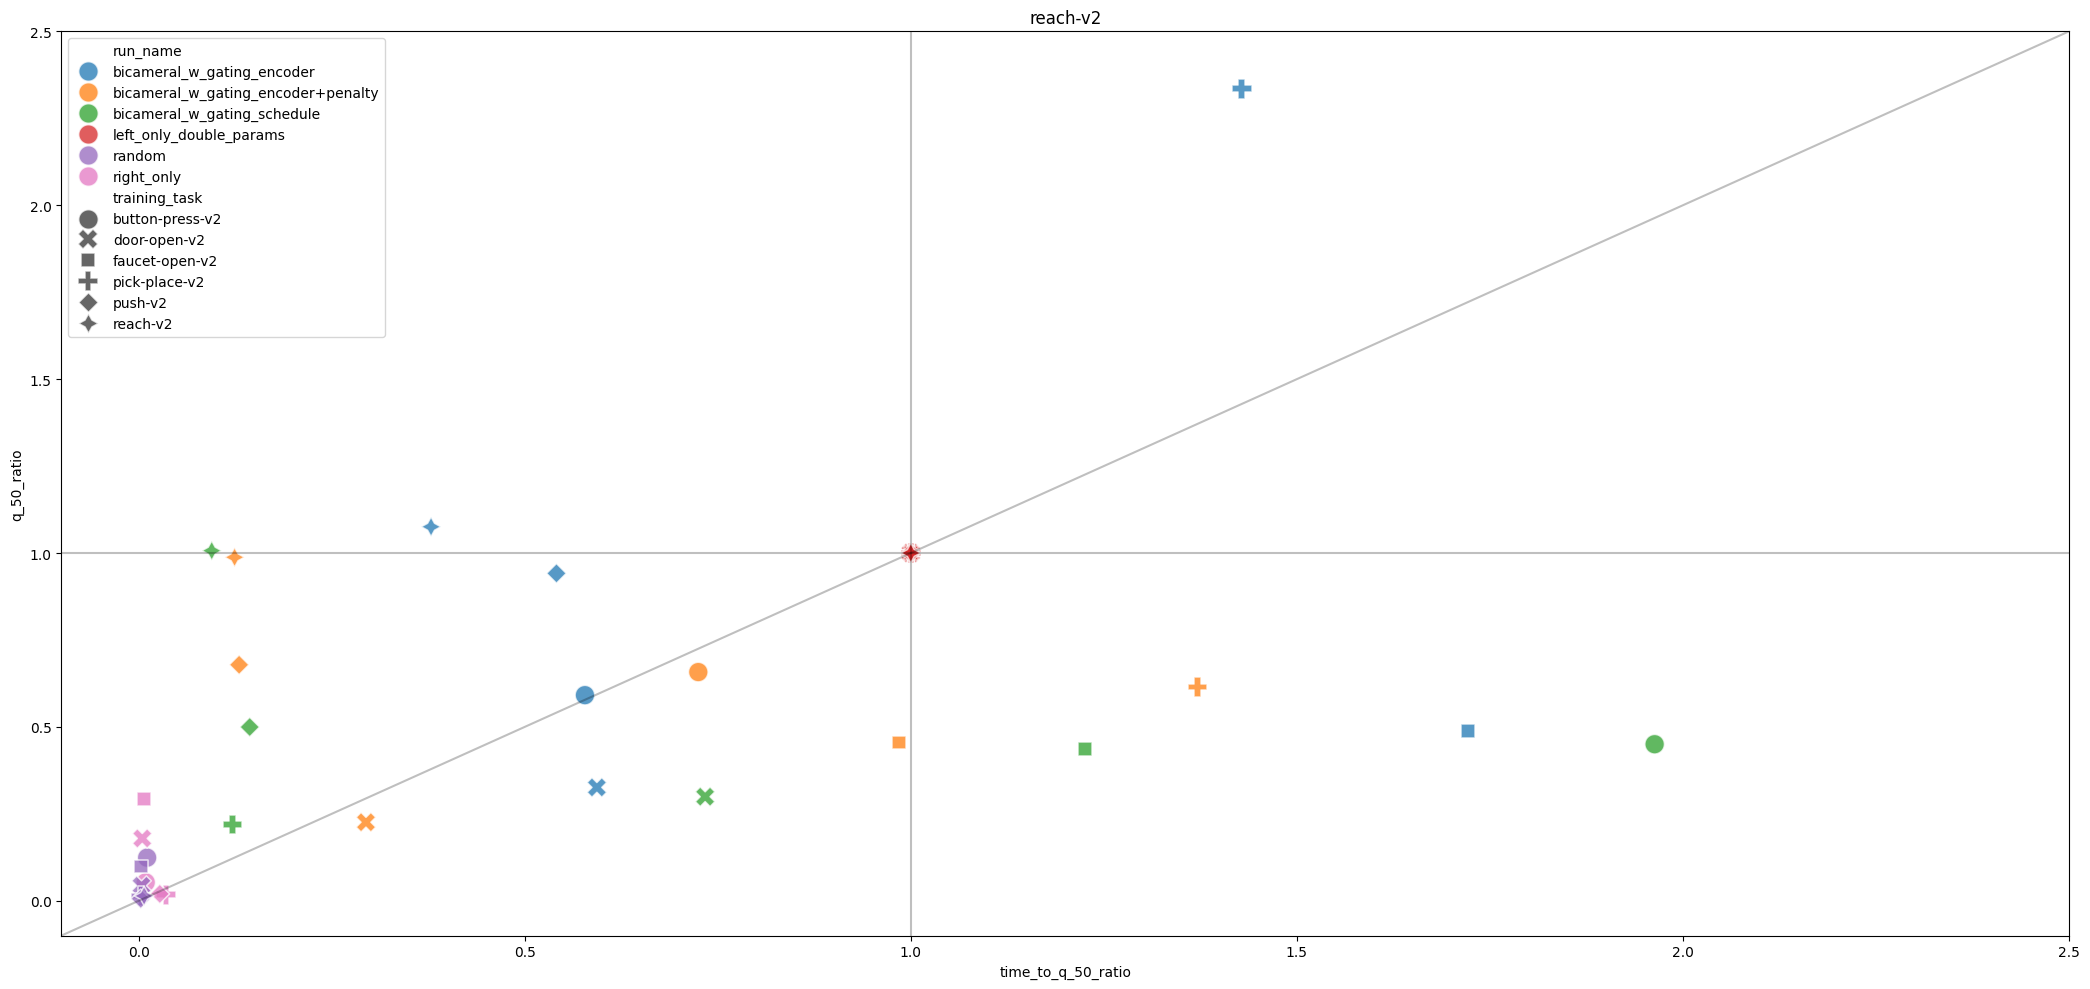

In [ ]:
quantiles_and_times = pd.concat([time_to_vals_dfs, q_to_left], axis=1).reset_index()
fig, ax = plt.subplots(figsize = (21, 10), sharex=True, sharey=True)
# ax = ax.flatten()
to_plot = 'q_50'

sns.scatterplot(
    data = (
        quantiles_and_times
    ),
    x=f'time_to_{to_plot}_ratio',
    y=f'{to_plot}_ratio',
    hue='run_name',
    ax=ax,
    palette=PALETTE,
    s = 200,
    alpha = 0.75,
    style='training_task'
)
ax.set_title(f"{task}")
ax.axhline(1, c='black', alpha=0.25)
ax.axvline(1, c='black', alpha=0.25)
ax.set_xlim(-.1, 2.5)
ax.set_ylim(-.1, 2.5)

ax.plot([-5., 5.], [-5.,5.], c='black', alpha=0.25)



plt.tight_layout()
plt.show();


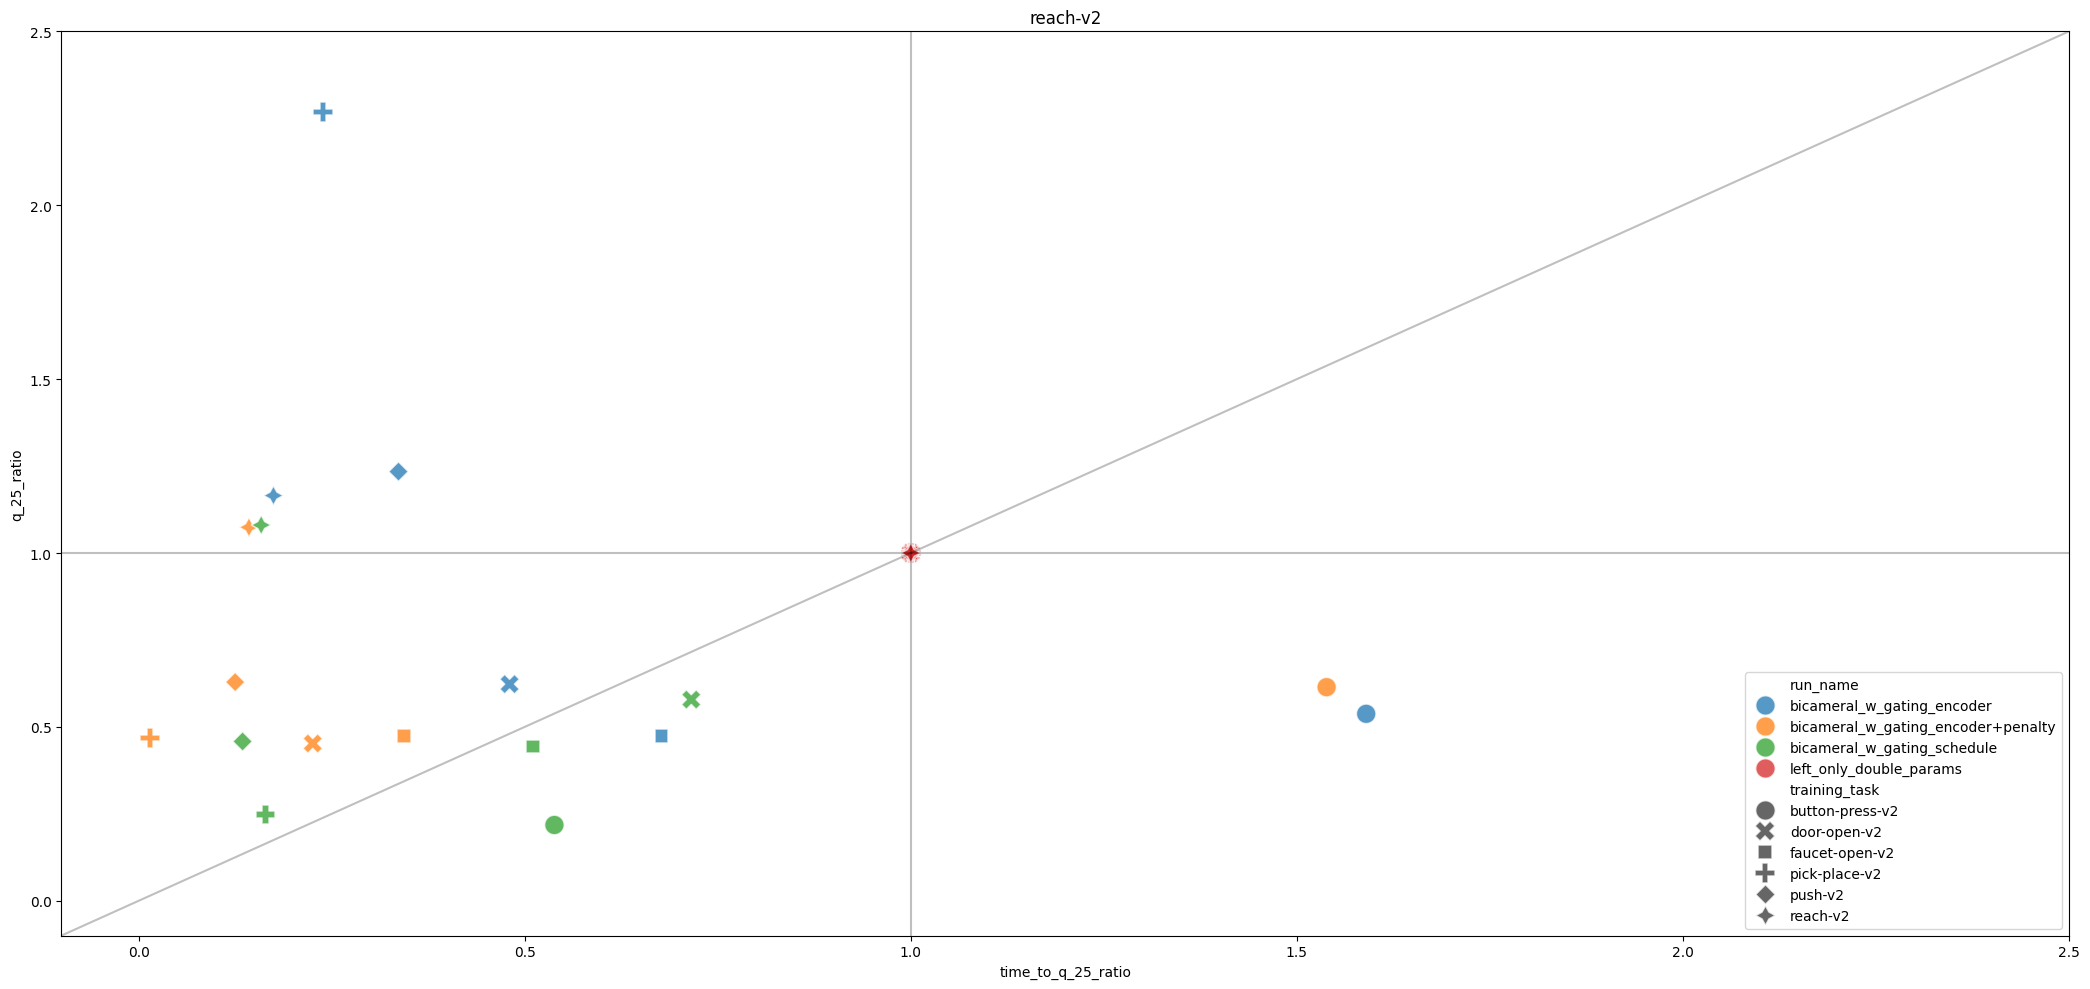

In [ ]:
fig, ax = plt.subplots(figsize = (21, 10), sharex=True, sharey=True)
# ax = ax.flatten()
to_plot = 'q_25'

sns.scatterplot(
    data = (
        quantiles_and_times.query(f"~run_name.isin({to_remove})")
    ),
    x=f'time_to_{to_plot}_ratio',
    y=f'{to_plot}_ratio',
    hue='run_name',
    ax=ax,
    palette=PALETTE,
    s = 200,
    alpha = 0.75,
    style='training_task'
)
ax.set_title(f"{task}")
ax.axhline(1, c='black', alpha=0.25)
ax.axvline(1, c='black', alpha=0.25)
ax.set_xlim(-.1, 2.5)
ax.set_ylim(-.1, 2.5)

ax.plot([-5., 5.], [-5.,5.], c='black', alpha=0.25)



plt.tight_layout()
plt.show();